In [157]:
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer


import collections
pd.options.mode.chained_assignment = None  # default='warn'
from collections import OrderedDict 

In [158]:
movie_data = pd.read_csv(r'data/movie_metadata.csv')
#movie_data = movie_data.replace('', np.nan)

# Data Wrangling

1. Column analysis
2. Key value: IMDB_id
3. Fill NaN values with other datasets
4. Filling or Removing Nan Values
5. Additional Data Preperation

### 1) Columns analysis:
    - color
    - year
    - aspect ratio

We check what columns are actually useful and we analyze these three, which must be edited.

In [159]:
print("The features of the movie datase are:")
print(movie_data.dtypes)

The features of the movie datase are:
color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64


**Color**

We check that the color column is binary: a film is 'black and white' or is 'color'. Then, we drop the color column, because we want to help a modern film company and it is gonna make color films quite surely. 

In fact, in the next cells we are gonna keep only movies produced after the 1980. Most of them are 'Color'.

In [160]:
colors = movie_data.color.unique() # values in the column color
color_values = [x for x in colors if str(x) != 'nan']# drop nan
#color_values[1] = color_values[1].strip() # delete spaces before 'black'
print(f"The color column has only {len(color_values)} different values: '{color_values[0]}' and '{color_values[1]}'.")

The color column has only 2 different values: 'Color' and ' Black and White'.


In [161]:
# dataframe years and colors:
year_color = movie_data[['color', 'title_year']] # we only need color and year
year_color = year_color[~year_color.color.isnull()] # deletete color NaN values 
year_color = year_color[~year_color.title_year.isnull()]  # deletete title NaN values 
year_color = year_color.sort_values('title_year') # sort by year

years = year_color.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years): 
    year = int(years[i]) # year
    year_movies = year_color.loc[year_color['title_year'] == years[i]].color.values # all colors of film of that year
    
    # number black and white and color movies for each year
    num_c = (year_movies == color_values[0]).sum()
    num_bw = (year_movies == color_values[1]).sum()
    
    # dataframe: for each row year, num colors, num blackwhite
    d = {'year':year , 'num_color':num_c , 'num_black_white':num_bw }
    
    if i==0 :
        year_number_colors = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_colors = year_number_colors.append(d2, ignore_index=True)
        
print("For each year, we check how many films are colored and how many black and white:")
year_number_colors = year_number_colors.set_index('year')
year_number_colors.head()

For each year, we check how many films are colored and how many black and white:


,num_color,num_black_white
year,,
1916,0,1
1920,0,1
1925,0,1
1927,0,1
1929,0,2


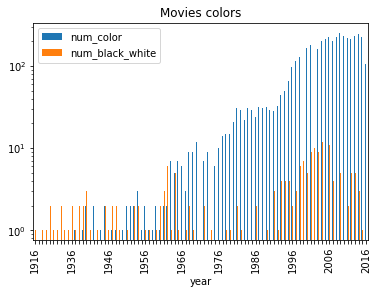

In [162]:
year_number_colors['year']=year_number_colors.index
f=year_number_colors.plot(x="year", y=["num_color", "num_black_white"], kind="bar")
plt.yscale('log', nonposy='clip')
plt.title("Movies colors")
for ind, label in enumerate(f.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
#f.set_yscale("log")

We can see that most of movies in recent years are color, so this column is not a relevant feature. We can drop it

In [163]:
movie_data = movie_data.drop('color', axis=1) # drop color column

**Year**

Custumers' tastes change really fastly. We have already decided to drop black and white films, because they are not relevant for the analysis. In the same way, we can ignore films which were produced before 1980. As it can be seen in this histogram, this choice does not drop the majority of the movies, which were produced after 1980.

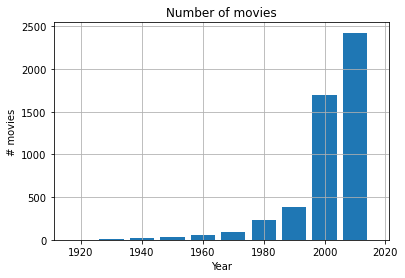

In [164]:
movie_data.title_year.hist( histtype='bar', width = 8)
plt.title("Number of movies")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

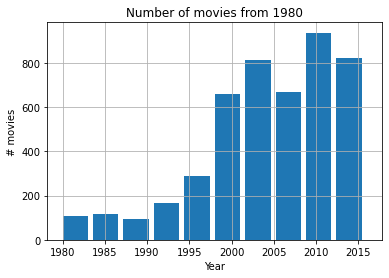

In [165]:
movie_data = movie_data[movie_data.title_year>=1980] # drop film before 1980
movie_data.title_year.hist(width = 3)
plt.title("Number of movies from 1980")
plt.ylabel("# movies")
plt.xlabel("Year")
plt.show()

**Aspect Ratio**

We want to anlyse if the aspect ratio is an intresting feature. Nowadays, there are some rules which says the ratio that film-makers must use (we cans earch something online). In order to do that we investigate for each year what aspect ratios were used. ù

For example wikipedia says (https://en.wikipedia.org/wiki/Aspect_ratio_(image)) :

The most common aspect ratios used today in the presentation of films in cinemas are 1.85:1 and 2.39:1.[2] Two common videographic aspect ratios are 4:3 (1.3:1),[a] the universal video format of the 20th century, and 16:9 (1.7:1), universal for high-definition television and European digital television. Other cinema and video aspect ratios exist, but are used infrequently.

In [166]:
ar = movie_data.aspect_ratio.unique() 
ar = [x for x in ar if str(x) != 'nan'] # drop nan
ar = sorted(ar) # sort 
print("The aspect ratios which were used were:")
print(*ar, sep = "\n")

The aspect ratios which were used were:
1.18
1.33
1.37
1.44
1.5
1.66
1.75
1.77
1.78
1.85
1.89
2.0
2.2
2.24
2.35
2.39
2.4
2.55
2.76
16.0


In [167]:
# dataframe years and aspect ratio:
year_ar = movie_data[['title_year', 'aspect_ratio']] # we only need color and year
year_ar = year_ar[~year_ar.aspect_ratio.isnull()] # deletete color NaN values 
year_ar = year_ar[~year_ar.title_year.isnull()]  # deletete title NaN values 
year_ar = year_ar.sort_values('title_year') # sort by year

years = year_ar.title_year.drop_duplicates().tolist() # years
n_years = len(years)

for i in range(n_years):  
    year = int(years[i]) # year
    year_movies = year_ar.loc[year_ar['title_year'] == years[i]].aspect_ratio.values # all colors of film of that year
    
    # number of each of the aspect ratios
    num = [] 
    for j in range(len(ar)): # for each aspect ratio
        sum_ar = (year_movies == ar[j]).sum()
        num.append(sum_ar) 
    
    # dataframe: for each row year, num of each aspect ratio
    d = dict(zip(ar, num)) # dictionary to create the dataframe
    
    d['year'] = year
    
    if i==0 :
        year_number_ar = pd.DataFrame( data = d , index = [year] )
    else: 
        #year_number_colors = pd.concat(d, ignore_index=True)
        d2 = pd.DataFrame( data = d , index = [year])
        year_number_ar = year_number_ar.append(d2, ignore_index=True)
        
print("For each year, we check the number of films:")
#year_number_ar = year_number_ar.set_index('year')
year_number_ar.head()

For each year, we check the number of films:


,1.18,1.33,1.37,1.44,1.5,1.66,1.75,1.77,1.78,1.85,...,2.0,2.2,2.24,2.35,2.39,2.4,2.55,2.76,16.0,year
0,0,0,1,0,0,0,0,0,0,11,...,0,0,0,12,0,0,0,0,0,1980
1,0,0,2,0,0,0,0,0,1,15,...,0,0,0,15,0,0,0,0,0,1981
2,0,0,0,0,0,0,0,0,0,12,...,0,0,0,16,0,0,0,0,0,1982
3,0,0,0,0,0,0,0,0,0,12,...,0,0,0,8,0,0,0,0,0,1983
4,0,0,0,0,0,0,0,0,0,21,...,0,1,0,9,0,0,0,0,0,1984


From this Data Frame we can see that 1.85 and 2.35 have way more movies than all the others ratios. We can plot these two and the sum of all the other and see that the other are irrelevant.

In [168]:
#we sum all the other columns: 

year_number_ar['sum'] =  year_number_ar[year_number_ar.columns[0]]
lista = [1,2,3,4,5,6,7,8,10,11,12,13,15,16,17,18,19]

for i in range(len(lista)):
    index = lista[i]
    year_number_ar['sum'] = year_number_ar['sum'] + year_number_ar[year_number_ar.columns[index]]

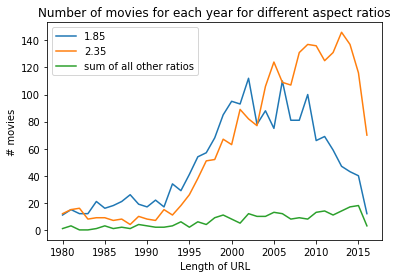

In [169]:
# plot:
# identification of the columns
ar_185 = year_number_ar.columns[9]
ar_235 = year_number_ar.columns[14]
ar_sum = year_number_ar.columns[21]


year_number_ar.plot(kind='line',x='year', y=[ar_185,ar_235, ar_sum])

plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.ylabel('# movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios")
plt.show()

This plot shows that in the last years most of the movies use only two aspect ratios. So, it is not a intresting feature: probablu there is some obbligation and our film company should not use this characteristic to decide the next investment. 
    
In particulare, we see a drop in the orange line after 2012. This does not mean that the customers prefer other aspect ratio. This is due to a geenral drop in film production. In fact, also other lines goes down. To show this we can use percentage:


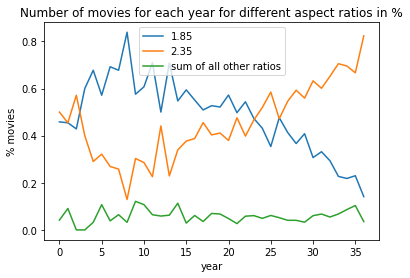

In [170]:
ar_185_perc = year_number_ar[year_number_ar.columns[9]].values
ar_235_perc = year_number_ar[year_number_ar.columns[14]].values
ar_sum_perc = year_number_ar[year_number_ar.columns[21]].values
at_tot = ar_185_perc + ar_235_perc + ar_sum_perc
years = year_number_ar.index.values


plt.plot(years,ar_185_perc/at_tot)
plt.plot(years,ar_235_perc/at_tot)
plt.plot(years,ar_sum_perc/at_tot)
plt.xlabel('year')
plt.ylabel('% movies')
plt.legend(['1.85','2.35','sum of all other ratios'])
plt.title("Number of movies for each year for different aspect ratios in %")
plt.show()

We will analize the general drop of number of films and possible reasons. Here we want to focus only on aspect ratio. In conclusion, we can drop this column. 

In [171]:
movie_data = movie_data.drop('aspect_ratio', axis=1) # drop aspect ratio column

### 2) Key value: IMDB_id

From the movie_imdb_link we extract the IMDB_id. It is useful to match this database with the another one, that we need to fill the NaN values. The reason why we do not use the title to match them is that the title is not an unique key: it can be inconsistent between different data sets (eg Capitalization). 
We check that this 'imdb_id' is unique and we set it as index 

In [172]:
# extraction of imdb_id 
movie_data['imdb_id'] = movie_data.movie_imdb_link.str.split('/').map(lambda row: row[4])
if movie_data.imdb_id.nunique() == len(movie_data.imdb_id): 
    movie_data = movie_data.set_index(imdb_id) # add imdb_id as a new column

movie_data = movie_data.drop('movie_imdb_link', axis=1) # drop link column
    
movie_data.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,imdb_id
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,33000,tt0499549
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,0,tt0449088
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,85000,tt2379713
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,164000,tt1345836
5,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,24000,tt0401729


Now, we cannot just set imdb_id as index: this is not an unique key right now. Before that, we have to delete duplicate rows. 

This is also the first step for the deletion of NaN values. In fact, a lot of NaN values derive from the fact that if a film is present twice, and not both lines have all the values.

In [173]:
print("Number of NaN values for each feature before dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature before dropping doplicate rows:


director_name                  0
num_critic_for_reviews        41
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        619
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                140
num_user_for_reviews          15
language                       5
country                        1
content_rating               255
budget                       375
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

From the DataFrame we delete duplicates movies. In order to do that, we sort our value for the number of NaN and we keep only the copy with the lower number of features with value NaN. 
This should not only delete duplicates, but also reduce the number of NaN for each feature.

In [174]:
movie_data = (
    movie_data.iloc[movie_data.isnull().sum(axis=1).mul(-1).argsort()] # Sort by number of NaN
        .drop_duplicates(subset='imdb_id', keep='last') # Remove duplicates taking last element
)

print("Number of NaN values for each feature after dropping doplicate rows:")
movie_data.isna().sum()

Number of NaN values for each feature after dropping doplicate rows:


director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
imdb_id                        0
dtype: int64

 A lot of features have less missing values. This makes our DataFrame more consistent. 
Moreover, now we have an unique key: imdb_id. Now, we can set it as index.

In [175]:
movie_data = movie_data.set_index('imdb_id') # set index
movie_data.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,autism|middle east|music therapy|united arab e...,NaN,Arabic,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,bisexual|explicit sex|sex|stranger|swing,8.0,English,USA,NaN,NaN,2002.0,NaN,4.7,51
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,american|blood|dream|patrol|tank,7.0,English,USA,NaN,120000.0,2005.0,NaN,6.6,14
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,city|city symphony|diary|essay|surveillance,1.0,English,USA,NaN,50000.0,2015.0,NaN,6.0,5
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,NaN,NaN,English,USA,PG-13,125000.0,2015.0,0.0,5.1,0


### 3) Fill NaN values with other datasets:
 - Wikipedia dataset
 - TMDb dataset

In [176]:
movie_data.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        604
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       369
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

**Wikipedia**

This is the Wikipedia query that we used to download data:

```
SELECT ?movieLabel (MAX(?grosses) as ?gross) (MIN(?costs) as ?cost) (MIN(?publicationYears) as ?publicationYear) ?IMDBid
WHERE 
{
  ?movie (wdt:P31/wdt:P279*) wd:Q11424;
                             wdt:P345 ?IMDBid;
                             wdt:P2142 ?grosses;
                             wdt:P577 ?publicationDate.
  
  OPTIONAL {?movie wdt:P2130 ?costs.}
  
  BIND(YEAR(?publicationDate) AS ?publicationYears)
  
  FILTER(?publicationYears >= (1980))
  
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
} GROUP BY ?movieLabel ?IMDBid
```

In [177]:
wiki_data = pd.read_csv('data/wiki_data.csv').drop('movieLabel', axis=1).set_index("IMDBid") # read data from the wiki_data csv
wiki_data = wiki_data.rename(columns={"gross":"gross_1"}) #rename gross column
wiki_data = wiki_data.sort_values(axis=0, by="IMDBid")
wiki_data.head()

,gross_1,cost,publicationYear
IMDBid,,,
tt0074486,7000000.0,100000.0,1980
tt0076709,1950391.0,NaN,1981
tt0078788,83471511.0,31500000.0,2019
tt0079417,106000000.0,NaN,1980
tt0080339,83453539.0,3500000.0,1980


In [178]:
# merge the two dataset on the imdb_id
movie_df = movie_data.merge(wiki_data, how='left', left_index=True, right_index=True)

In [179]:
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,gross_1,cost,publicationYear
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt2638024,Amal Al-Agroobi,NaN,62.0,58.0,NaN,NaN,NaN,NaN,Documentary|Family,NaN,...,United Arab Emirates,NaN,125000.0,2013.0,NaN,8.2,54,NaN,NaN,NaN
tt0304692,Harry Gantz,12.0,105.0,0.0,NaN,NaN,NaN,247740.0,Documentary|Drama,NaN,...,USA,NaN,NaN,2002.0,NaN,4.7,51,NaN,NaN,NaN
tt0488873,Andrew Berends,12.0,90.0,0.0,NaN,NaN,NaN,NaN,Documentary|War,NaN,...,USA,NaN,120000.0,2005.0,NaN,6.6,14,NaN,NaN,NaN
tt4462082,Jem Cohen,12.0,111.0,6.0,NaN,NaN,NaN,NaN,Documentary,NaN,...,USA,NaN,50000.0,2015.0,NaN,6.0,5,NaN,NaN,NaN
tt4607906,Valentine,NaN,NaN,0.0,NaN,Valentine,17.0,NaN,Romance,Diane Sorrentino,...,USA,PG-13,125000.0,2015.0,0.0,5.1,0,NaN,NaN,NaN


In [180]:
movie_data.shape, movie_df.shape

((4560, 25), (4560, 28))

Now we have some repeated columns:
- gross
- costs

We have to keep only one of them. Instead of deleting one without an analysis. we match them in order to delete as many NaN values as possible

- grosses:

In [181]:
# gross :   gross from movie dataset
# gorss_1 : gross from wiki dataset

gross_movie_na = movie_df.gross.isna()

for i in range(len(gross_movie_na)): # for each film
    if gross_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.gross[i] = movie_df.gross_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('gross_1', axis=1) # drop link gross wiki column

- costs:

In [182]:
# budget :   cost from movie dataset
# cost :     cost from wiki dataset

cost_movie_na = movie_df.budget.isna()


for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.cost[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['cost','publicationYear'], axis=1) # drop link cost wiki column

Now we can see that the number of movies with empty values in gross and budget has decreased :)

In [183]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                138
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       359
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

**TMDb**

In [184]:
tmdb_data = pd.read_csv('data/tmdb_movies_data.csv').set_index("imdb_id") # read data from the wiki_data csv
tmdb_data = tmdb_data.rename(columns={"budget":"budget_1"}) #rename gross column
tmdb_data = tmdb_data[['budget_1','revenue','keywords','release_year']]
tmdb_data.head()

,budget_1,revenue,keywords,release_year
imdb_id,,,,
tt0369610,150000000,1513528810,monster|dna|tyrannosaurus rex|velociraptor|island,2015
tt1392190,150000000,378436354,future|chase|post-apocalyptic|dystopia|australia,2015
tt2908446,110000000,295238201,based on novel|revolution|dystopia|sequel|dyst...,2015
tt2488496,200000000,2068178225,android|spaceship|jedi|space opera|3d,2015
tt2820852,190000000,1506249360,car race|speed|revenge|suspense|car,2015


In [185]:
movie_df = movie_df.merge(tmdb_data, how='left', left_index=True, right_index=True)
movie_df = movie_df.drop(['release_year','revenue'], axis=1)
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes,budget_1,keywords
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0,0.0,lover (female)|love of one's life|time travel|...
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000,3500000.0,chicago|alcohol|cataclysm|guitar|medicine
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,English,USA,R,4500000.0,1980.0,511.0,5.7,0,4500000.0,sexual identity|shipwreck|lovers|stranded|maro...
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,English,USA,R,27000000.0,1980.0,809.0,7.9,14000,27000000.0,dancing|prison|chicago|country music|nun
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,English,USA,R,6000000.0,1980.0,573.0,7.4,0,6000000.0,golf|underwear|sport|golf course|gopher


**budget**

In [186]:
# budget :   cost from movie dataset
# budget_1 :     cost from TDM  dataset

cost_movie_na = movie_df.budget.isna()

for i in range(len(cost_movie_na)): # for each film
    if cost_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.budget[i] = movie_df.budget_1[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop('budget_1', axis=1) # drop link cost wiki column

**keywords**

In [187]:
# plot_keywords :    from movie dataset
# keywords :      from TDM  dataset

keywords_movie_na = movie_df.plot_keywords.isna()

for i in range(len(keywords_movie_na)): # for each film
    if keywords_movie_na[i]==True: # NaN value => we keep the new value
        movie_df.plot_keywords[i] = movie_df.keywords[i] # copy the wiki value in the movie one

# if it is not NaN we don't do anyting
 
# we delete the wiki gross column: we have used the values we need and now it's useless
movie_df = movie_df.drop(['keywords'], axis=1) # drop link cost wiki column

In [188]:
movie_df.isna().sum()

director_name                  0
num_critic_for_reviews        40
duration                      12
director_facebook_likes        0
actor_3_facebook_likes        16
actor_2_name                  10
actor_1_facebook_likes         7
gross                        577
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  16
facenumber_in_poster          13
plot_keywords                129
num_user_for_reviews          15
language                       5
country                        1
content_rating               253
budget                       171
title_year                     0
actor_2_facebook_likes        10
imdb_score                     0
movie_facebook_likes           0
dtype: int64

### 4) Filling or Removing NaN Values

In [189]:
movie_df = movie_df.dropna(subset=['country'])
movie_df.gross = movie_df.gross.fillna(0)
movie_df.budget = movie_df.budget.fillna(0)

In [190]:
NotFamous = {'actor_2_name': 'No Second Actor', 'actor_1_name': 'No Actor', 'actor_3_name': 'No Third Actor'}
movie_df = movie_df.fillna(value=NotFamous)
NotFBlikes = {'actor_3_facebook_likes': 0, 'actor_2_facebook_likes': 0, 'actor_1_facebook_likes': 0}
movie_df = movie_df.fillna(value=NotFBlikes)
NotRated = {'content_rating': 'Not Rated'}
movie_df = movie_df.fillna(value=NotRated)

In [191]:
movie_df.loc['tt3949660', 'facenumber_in_poster']=4
movie_df.loc['tt0903624', 'facenumber_in_poster']=1
movie_df.loc['tt3567288', 'facenumber_in_poster']=0
movie_df.loc['tt0989757', 'facenumber_in_poster']=2
movie_df.loc['tt1929263', 'facenumber_in_poster']=0
movie_df.loc['tt3014666', 'facenumber_in_poster']=6

In [192]:
movie_df=movie_df.dropna()
movie_df=movie_df.replace({'content_rating': {'Unrated': 'Not Rated'}})
movie_df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,plot_keywords,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,bridge|brooklyn bridge|falling down an elevato...,316.0,English,USA,PG-13,48000000.0,2001.0,1000.0,6.4,0
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,air traffic controller|airplane|airport|pilot|...,427.0,English,USA,PG,3500000.0,1980.0,575.0,7.8,16000
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,coming of age|island|poison|teenage boy|teenag...,140.0,English,USA,R,4500000.0,1980.0,511.0,5.7,0
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,band|catholic|money|parolee|prison,319.0,English,USA,R,27000000.0,1980.0,809.0,7.9,14000
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,caddy|country club|golf course|gopher|nudity,250.0,English,USA,R,6000000.0,1980.0,573.0,7.4,0


In [193]:
movie_df.isna().sum()

director_name                0
num_critic_for_reviews       0
duration                     0
director_facebook_likes      0
actor_3_facebook_likes       0
actor_2_name                 0
actor_1_facebook_likes       0
gross                        0
genres                       0
actor_1_name                 0
movie_title                  0
num_voted_users              0
cast_total_facebook_likes    0
actor_3_name                 0
facenumber_in_poster         0
plot_keywords                0
num_user_for_reviews         0
language                     0
country                      0
content_rating               0
budget                       0
title_year                   0
actor_2_facebook_likes       0
imdb_score                   0
movie_facebook_likes         0
dtype: int64

# Feature Engineering and pre-data processing
- One Hot encoding:
    - Genres
- Rating
    - Director
    - Actors: actor 1, actor 2, actor 3
- Filling Missing Budget Values

## Country

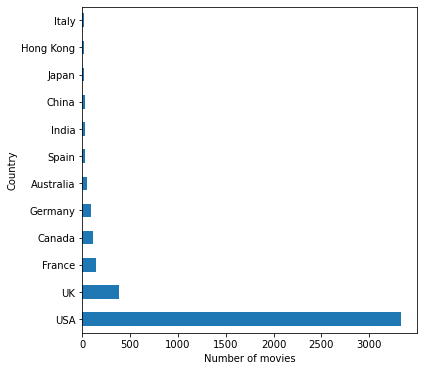

In [194]:
mlb = MultiLabelBinarizer()
country = movie_df.country.values
#encoded_country = pd.DataFrame(country, columns=mlb.classes_, index=movie_df.index)
count_country = Counter(country)
count_country = {k: v for k, v in sorted(count_country.items(), key=lambda item: item[1], reverse = True)}
count_country = dict(itertools.islice(count_country.items(), 12)) 
dd = pd.DataFrame(count_country.items())
dd = dd.set_index(0)

fig, ax = plt.subplots(figsize=(6,6))
dd.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Country')
plt.show()

We have taken our data from different sources and we do not know, for movies which are not American, in which currencies the budget and the gross are. Hence, considering that the large majority of movies are American and that we suppose to do our analysis for an American company, we can drop all movies which are not produced in USA. In this way we avoid potential and dangerous currency-related mistakes.

In [195]:
movie_df = movie_df[movie_df.country == 'USA']

## Genre

In [196]:
mlb = MultiLabelBinarizer()
genres = movie_df.genres.str.split("|")
encoded_genres = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=movie_df.index)
encoded_genres

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
tt0080339,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0080453,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
tt0080455,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt0080487,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4651520,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4667094,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4733536,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


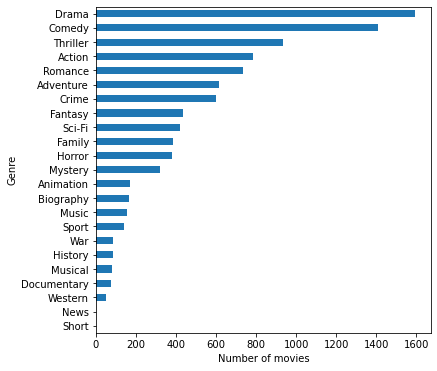

In [197]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

We can group togheter similar genres, in order to decrease the number of columns

In [198]:
# Mystery|Thriller|Horror
sum_gen = encoded_genres[['Mystery','Thriller','Horror']].sum(axis=1)
encoded_genres['Mystery_Thriller_Horror'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Mystery','Thriller','Horror'], axis=1) #drop other

#Sci-Fi|Fantasy
sum_gen = encoded_genres[['Sci-Fi','Fantasy']].sum(axis=1)
encoded_genres['Sci-Fi_Fantasy'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Sci-Fi','Fantasy'], axis=1) #drop other

#Family|Animation
sum_gen = encoded_genres[['Family','Animation']].sum(axis=1)
encoded_genres['Family_Animation'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Family','Animation'], axis=1) #drop other

#Action|Adventure
sum_gen = encoded_genres[['Action','Adventure']].sum(axis=1)
encoded_genres['Action_Adventure'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['Action','Adventure'], axis=1) #drop other

#History|War
sum_gen = encoded_genres[['History','War']].sum(axis=1)
encoded_genres['History_War'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(['History','War'], axis=1) #drop other


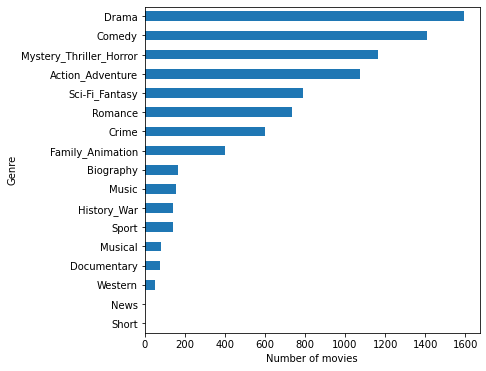

In [199]:
count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()

At this point we can put togheter genres which are not common:

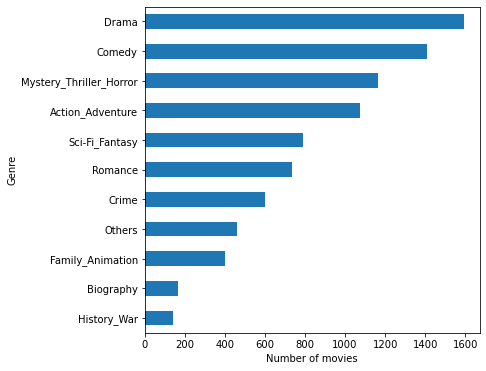

In [200]:
#Other
other = ['Music','Sport','Documentary','Musical','Western','Short','News']

sum_gen = encoded_genres[other].sum(axis=1)
encoded_genres['Others'] = np.array([sum_gen.values>0]).astype(int).T # add column if movie is one of them
encoded_genres = encoded_genres.drop(other, axis=1) #drop other

# Add genres columns to movie_df
movie_df = movie_df.merge(encoded_genres,how='left', left_index=True, right_index=True)

count_encoded_genres = encoded_genres.sum().sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(6,6))
count_encoded_genres.plot(kind='barh', legend = False, ax=ax)
ax.set_xlabel('Number of movies')
ax.set_ylabel('Genre')
plt.show()


## Director

In [201]:
group_director = movie_df.groupby('director_name') # group the database for the director
directors = list(movie_df.director_name.values) #director list
directors_unique =list(OrderedDict.fromkeys(directors)) # no duplicates

#number of movies for each director
#counter = collections.Counter(directors)
results = [directors.count(x) for x in directors_unique] #number of films
directors = pd.DataFrame([directors_unique, results], index=['director', 'num_movies']).T
directors = directors.set_index('director')
directors.head()

,num_movies
director,
James Mangold,8
Jim Abrahams,1
Randal Kleiser,2
John Landis,3
Harold Ramis,8


In the regression, we cannot use variables which are consequnces, as movie_facebook_likes. However, we can use them to understand how much a director is famous. If a film has a lot of likes, its director will probably earn a good reputation.

Same reasoning for imdb_score

In [202]:
# mean movie_facebook_likes for the movies did by that director
num_likes = group_director.mean().movie_facebook_likes
directors = directors.merge(num_likes,how='left', left_index=True, right_index=True)

# mean movie_facebook_likes for the movies did by that director
score = group_director.mean().imdb_score
directors = directors.merge(score, how='left', left_index=True, right_index=True)

directors.head(10)

,num_movies,movie_facebook_likes,imdb_score
director,,,
James Mangold,8,12875.000000,7.075000
Jim Abrahams,1,16000.000000,7.800000
Randal Kleiser,2,0.000000,6.200000
John Landis,3,4889.666667,6.966667
Harold Ramis,8,4855.750000,6.550000
Nancy Walker,1,1000.000000,4.500000
Michael Apted,5,4870.400000,6.540000
Brian De Palma,10,2298.000000,6.830000
David Lynch,2,10000.000000,7.400000


Director:


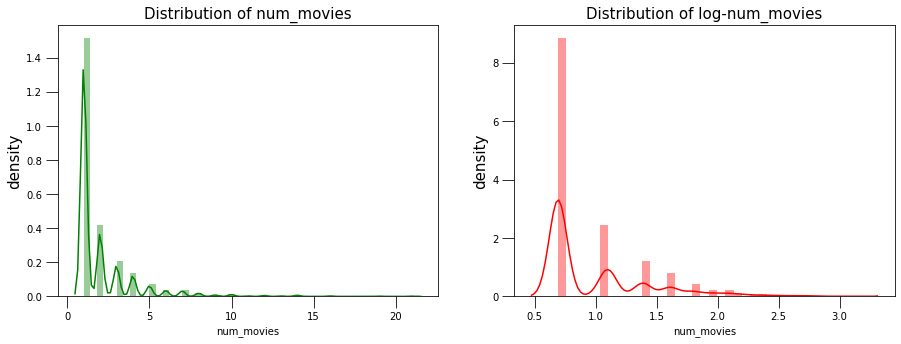

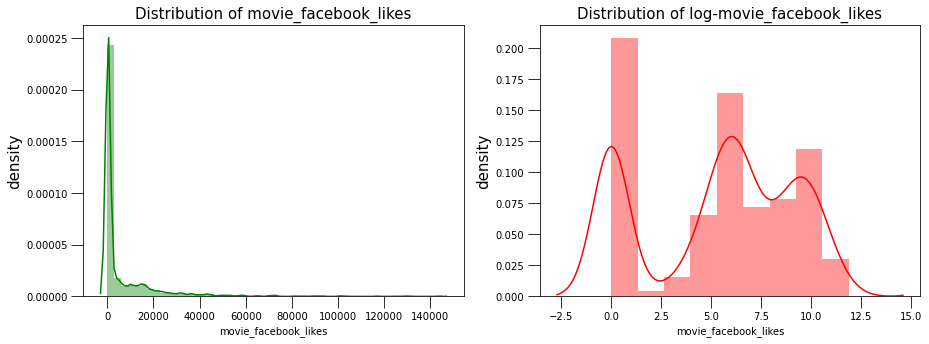

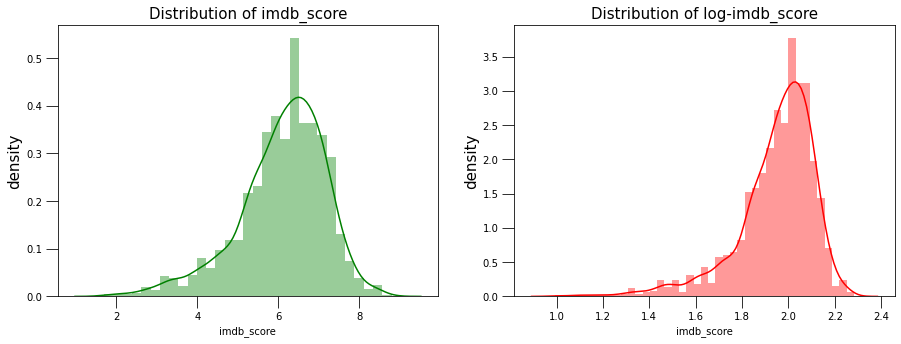

In [203]:
print("Director:")
for col in ["num_movies", "movie_facebook_likes", "imdb_score"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(directors[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(directors[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

Using these three features, we can create a ranking for the directors. We consider 10 levels. If a director is in level 10, he is really important: he has done a lot of movies with high ranking. 

In order to do that, we 
- trasform this variables in values between 0 and 1
- do the mean of each column (same weight for each feature)
- create 10 groups

In [204]:
#we divide wach value for the max of that column in order to have values between 0 and 1
directors.num_movies = directors.num_movies/directors.num_movies.max()

'''# log for likes 
max_likes = np.log(directors.movie_facebook_likes.max())
directors.movie_facebook_likes = [1 if x == 0 else x for x in directors.movie_facebook_likes.values] # edit zeros to use log
directors.movie_facebook_likes = directors.movie_facebook_likes/max_likes
directors.imdb_score = directors.imdb_score/directors.imdb_score.max()'''

#we consider that each column has the same weight and we do the mean 
directors['mean_'] = directors.num_movies*1/2 + directors.imdb_score*1/2
massimo = directors.mean_.max()
directors['director_rank'] = [int(x) for x in directors.mean_/massimo*10]
directors = directors.drop(columns='movie_facebook_likes')

directors = directors.sort_values(['director_rank','num_movies'], ascending=False)

directors.head(20)

,num_movies,imdb_score,mean_,director_rank
director,,,,
Irvin Kershner,0.047619,8.800000,4.42381,10
Steven Spielberg,1,7.547619,4.27381,9
Clint Eastwood,0.904762,7.205263,4.05501,9
Martin Scorsese,0.761905,7.662500,4.2122,9
David Fincher,0.47619,7.750000,4.1131,9
Quentin Tarantino,0.380952,8.200000,4.29048,9
Christopher Nolan,0.380952,8.425000,4.40298,9
James Cameron,0.285714,7.883333,4.08452,9
Peter Jackson,0.238095,8.020000,4.12905,9


In [205]:
directors.sort_values(by=['imdb_score'], ascending=False)

,num_movies,imdb_score,mean_,director_rank
director,,,,
Irvin Kershner,0.047619,8.800,4.42381,10
Ron Fricke,0.047619,8.500,4.27381,9
Damien Chazelle,0.047619,8.500,4.27381,9
Tony Kaye,0.0952381,8.450,4.27262,9
Christopher Nolan,0.380952,8.425,4.40298,9
...,...,...,...,...
Georgia Hilton,0.047619,2.200,1.12381,2
Vondie Curtis-Hall,0.047619,2.100,1.07381,2
Don Michael Paul,0.047619,2.000,1.02381,2


In [206]:
print("Less influent directors:")
directors.sort_values(by=['director_rank']).head()

Less influent directors:


,num_movies,imdb_score,mean_,director_rank
director,,,,
Lawrence Kasanoff,0.047619,1.7,0.87381,1
Vondie Curtis-Hall,0.047619,2.1,1.07381,2
Alex Zamm,0.047619,2.3,1.17381,2
Roger Christian,0.047619,2.4,1.22381,2
Georgia Hilton,0.047619,2.2,1.12381,2


### Actors
- Actor1
- Actor2
- Actor3

w do not want to use directly the column of actors_facebook_likes because we would like also to consider how many films they have done. 

**Actor 1**

In [207]:
# actor_1_name
actor1 = movie_df.groupby('actor_1_name') # group the database for the actor_1_name
actors1 = list(movie_df.actor_1_name.values) #director list
actors1_unique =list(OrderedDict.fromkeys(actors1)) # no duplicates

#number of movies for each actor1
results = [actors1.count(x) for x in actors1_unique] #number of films
actors1 = pd.DataFrame([actors1_unique, results], index=['actors1', 'num_movies']).T
actors1 = actors1.set_index('actors1')

# mean actor_1_facebook_likes for the movies did by that director
num_likes = actor1.mean().actor_1_facebook_likes
actors1 = actors1.merge(num_likes, how='left', left_index=True, right_index=True)

actors1.head(5)

,num_movies,actor_1_facebook_likes
actors1,,
Hugh Jackman,14,20000.0
Peter Graves,1,628.0
Brooke Shields,1,1000.0
John Belushi,1,1000.0
Bill Murray,25,13000.0


Actor1:


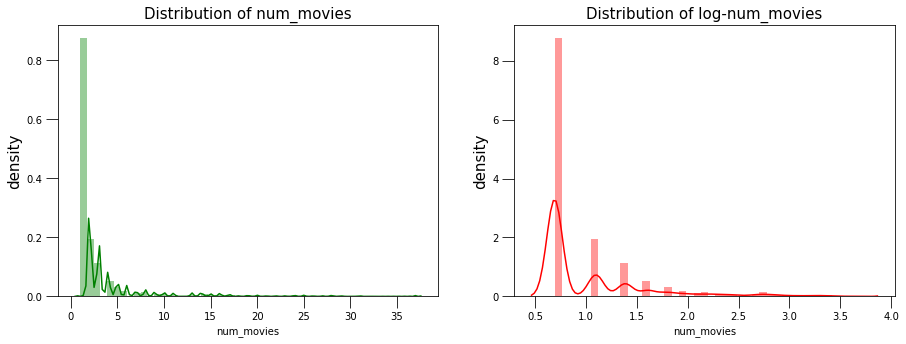

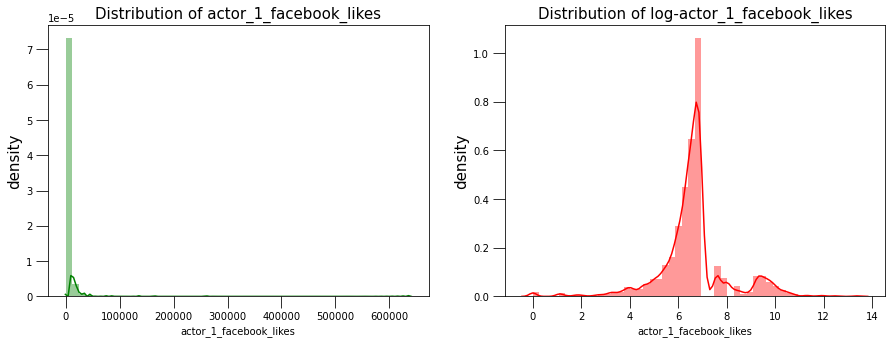

In [208]:
print("Actor1:")
for col in ["num_movies", "actor_1_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors1[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors1[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [209]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors1.num_movies = actors1.num_movies/actors1.num_movies.max()
# log for facebook likes
max_likes = np.log(actors1.actor_1_facebook_likes.max())
actors1.actor_1_facebook_likes = [1 if x == 0 else x for x in actors1.actor_1_facebook_likes.values] # edit zeros to use log
actors1.actor_1_facebook_likes = np.log(actors1.actor_1_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors1['mean_'] = actors1.num_movies*1/2 + actors1.actor_1_facebook_likes*1/2
massimo = actors1.mean_.max()
actors1['actor1_rank'] = [int(x) for x in actors1.mean_/massimo*10]

actors1 = actors1.sort_values(['actor1_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Actor',0,0,0,0]],columns=['actors1','num_movies','actor_1_facebook_likes','mean_','actor1_rank']).set_index('actors1')
actors1 = actors1.append(df2)

actors1.head(10)

,num_movies,actor_1_facebook_likes,mean_,actor1_rank
actors1,,,,
Robert De Niro,1,0.747897,0.873948,10
Johnny Depp,0.837838,0.792614,0.815226,9
J.K. Simmons,0.783784,0.754405,0.769094,8
Nicolas Cage,0.756757,0.702559,0.729658,8
Denzel Washington,0.756757,0.732887,0.744822,8
Matt Damon,0.72973,0.708546,0.719138,8
Bruce Willis,0.702703,0.708546,0.705624,8
Robin Williams,0.648649,0.807794,0.728221,8
Bill Murray,0.675676,0.708546,0.692111,7


In [210]:

actors1.head()

,num_movies,actor_1_facebook_likes,mean_,actor1_rank
actors1,,,,
Robert De Niro,1,0.747897,0.873948,10
Johnny Depp,0.837838,0.792614,0.815226,9
J.K. Simmons,0.783784,0.754405,0.769094,8
Nicolas Cage,0.756757,0.702559,0.729658,8
Denzel Washington,0.756757,0.732887,0.744822,8


**Actor 2**

In [211]:
# actor_2_name
actor2 = movie_df.groupby('actor_2_name') # group the database for the actor_2_name
actors2 = list(movie_df.actor_2_name.values) #director list
actors2_unique =list(OrderedDict.fromkeys(actors2)) # no duplicates

#number of movies for each actor2
results = [actors2.count(x) for x in actors2_unique] #number of films
actors2 = pd.DataFrame([actors2_unique, results], index=['actors2', 'num_movies']).T
actors2 = actors2.set_index('actors2')

# mean actor_2_facebook_likes for the movies did by that director
num_likes = actor2.mean().actor_2_facebook_likes
actors2 = actors2.merge(num_likes,how='left', left_index=True, right_index=True)

actors2.head(5)

,num_movies,actor_2_facebook_likes
actors2,,
Natasha Lyonne,2,1000.0
Lloyd Bridges,1,575.0
Christopher Atkins,1,511.0
Aretha Franklin,1,809.0
Rodney Dangerfield,1,573.0


Actor2:


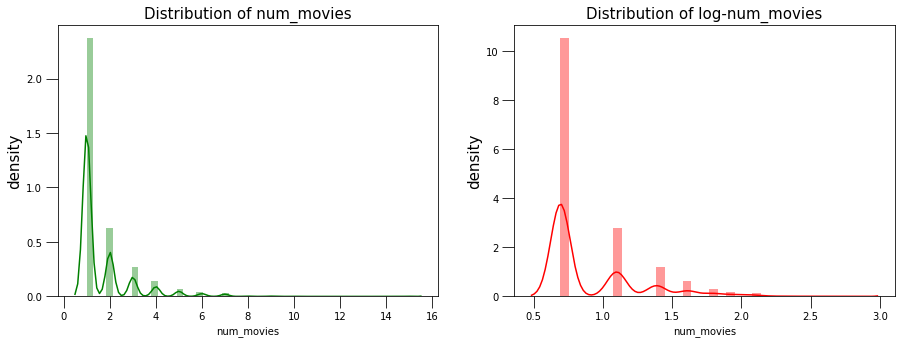

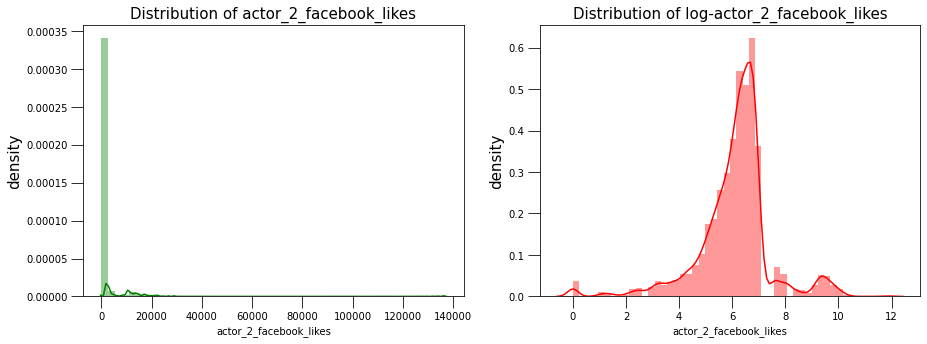

In [212]:
print("Actor2:")
for col in ["num_movies", "actor_2_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors2[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors2[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [213]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors2.num_movies = actors2.num_movies/actors2.num_movies.max()
# log for facebook likes
max_likes = np.log(actors2.actor_2_facebook_likes.max())
actors2.actor_2_facebook_likes = [1 if x == 0 else x for x in actors2.actor_2_facebook_likes.values] # edit zeros to use log
actors2.actor_2_facebook_likes = np.log(actors2.actor_2_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors2['mean_'] = actors2.num_movies*1/2 + actors2.actor_2_facebook_likes*1/2
massimo = actors2.mean_.max()
actors2['actor2_rank'] = [int(x) for x in actors2.mean_/massimo*10]

actors2 = actors2.sort_values(['actor2_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Second Actor',0,0,0,0]],columns=['actors2','num_movies','actor_2_facebook_likes','mean_','actor2_rank']).set_index('actors2')
actors2 = actors2.append(df2)

actors2.head(10)

,num_movies,actor_2_facebook_likes,mean_,actor2_rank
actors2,,,,
Morgan Freeman,1,0.786765,0.893383,10
Charlize Theron,0.8,0.769799,0.7849,8
Brad Pitt,0.733333,0.786765,0.760049,8
Adam Sandler,0.666667,0.786765,0.726716,8
Meryl Streep,0.6,0.786765,0.693383,7
James Franco,0.6,0.786765,0.693383,7
Bruce Willis,0.533333,0.800889,0.667111,7
Zooey Deschanel,0.533333,0.786765,0.660049,7
Steve Buscemi,0.466667,0.794122,0.630394,7


**Actor 3**

In [214]:
# actor_3_name
actor3 = movie_df.groupby('actor_3_name') # group the database for the actor_3_name
actors3 = list(movie_df.actor_3_name.values) #director list
actors3_unique =list(OrderedDict.fromkeys(actors3)) # no duplicates

#number of movies for each actor3
results = [actors3.count(x) for x in actors3_unique] #number of films
actors3 = pd.DataFrame([actors3_unique, results], index=['actors3', 'num_movies']).T
actors3 = actors3.set_index('actors3')

# mean actor_3_facebook_likes for the movies did by that director
num_likes = actor3.mean().actor_3_facebook_likes
actors3 = actors3.merge(num_likes,how='left', left_index=True, right_index=True)

actors3.head(5)

,num_movies,actor_3_facebook_likes
actors3,,
Bradley Whitford,1,821.0
Barbara Billingsley,1,318.0
Leo McKern,2,83.0
Ray Charles,1,326.0
Brian Doyle-Murray,2,484.0


Actor3:


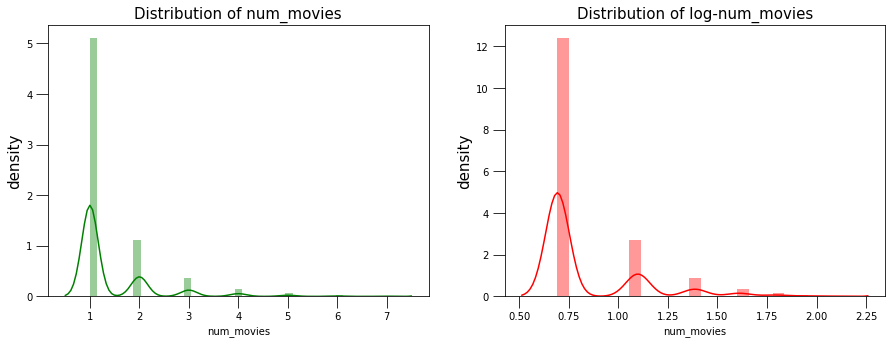

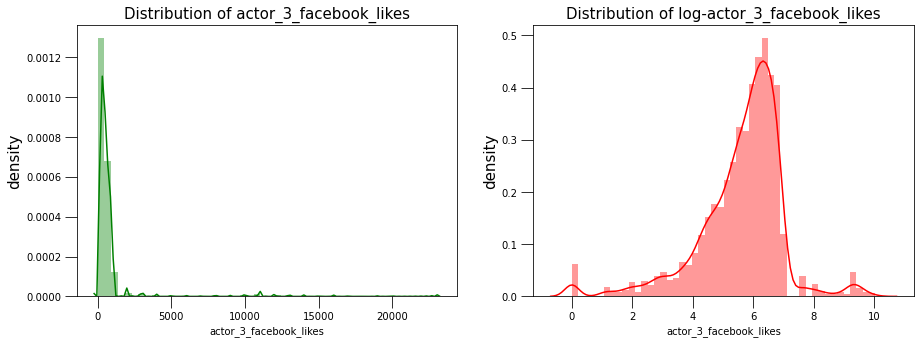

In [215]:
print("Actor3:")
for col in ["num_movies", "actor_3_facebook_likes"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(actors3[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(actors3[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [216]:
#we divide wach value for the max of that column in order to have values between 0 and 1
actors3.num_movies = actors3.num_movies/actors3.num_movies.max()
# log for facebook likes
max_likes = np.log(actors3.actor_3_facebook_likes.max())
actors3.actor_3_facebook_likes = [1 if x == 0 else x for x in actors3.actor_3_facebook_likes.values] # edit zeros to use log
actors3.actor_3_facebook_likes = np.log(actors3.actor_3_facebook_likes)/max_likes

#we consider that each column has the same weight and we do the mean 
actors3['mean_'] = actors3.num_movies*1/2 + actors3.actor_3_facebook_likes*1/2
massimo = actors3.mean_.max()
actors3['actor3_rank'] = [int(x) for x in actors3.mean_/massimo*10]

actors3 = actors3.sort_values(['actor3_rank','num_movies'], ascending=False)

# add row for no actor
#actors1 = actors1.append(fill, ignore_index=False, verify_integrity=False, sort=None)
df2 = pd.DataFrame([['No Third Actor',0,0,0,0]],columns=['actors3','num_movies','actor_3_facebook_likes','mean_','actor3_rank']).set_index('actors3')
actors3 = actors3.append(df2)

actors3.head(10)

,num_movies,actor_3_facebook_likes,mean_,actor3_rank
actors3,,,,
Anne Hathaway,0.857143,0.926558,0.89185,10
Sam Shepard,1,0.668041,0.834021,9
Stephen Root,1,0.681534,0.840767,9
Steve Coogan,1,0.687801,0.8439,9
Steve Carell,0.857143,0.881554,0.869348,9
John Heard,0.857143,0.651859,0.754501,8
Joan Allen,0.857143,0.666203,0.761673,8
Hope Davis,0.857143,0.606508,0.731825,8
Kevin Pollak,0.857143,0.632527,0.744835,8


Add director and actors ratings to movie_df:

In [217]:
movie_df['imdb_id'] = movie_df.index
movie_df = pd.merge(left=movie_df, right=directors.director_rank , left_on='director_name', right_on='director')
movie_df = pd.merge(left=movie_df, right=actors1.actor1_rank , left_on='actor_1_name', right_on='actors1')
movie_df = pd.merge(left=movie_df, right=actors2.actor2_rank , left_on='actor_2_name', right_on='actors2')
movie_df = pd.merge(left=movie_df, right=actors3.actor3_rank , left_on='actor_3_name', right_on='actors3')

movie_df = movie_df.sort_values(by='imdb_id').drop_duplicates(subset='imdb_id', keep='last').set_index('imdb_id')
movie_df

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,Hugh Jackman,...,0,1,0,0,0,0,8,6,4,4
tt0080339,Jim Abrahams,134.0,88.0,104.0,318.0,Lloyd Bridges,628.0,83400000.0,Comedy,Peter Graves,...,0,0,0,0,0,0,8,2,3,4
tt0080453,Randal Kleiser,36.0,104.0,116.0,83.0,Christopher Atkins,1000.0,58853106.0,Adventure|Drama|Romance,Brooke Shields,...,0,0,0,1,0,0,7,3,3,4
tt0080455,John Landis,125.0,148.0,644.0,326.0,Aretha Franklin,1000.0,54200000.0,Action|Comedy|Crime|Music,John Belushi,...,0,0,0,1,0,1,8,3,3,4
tt0080487,Harold Ramis,71.0,98.0,11000.0,484.0,Rodney Dangerfield,13000.0,39800000.0,Comedy|Sport,Bill Murray,...,0,0,0,0,0,1,7,7,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4651520,Jon Lucas,81.0,100.0,24.0,851.0,Jay Hernandez,15000.0,55461307.0,Comedy,Mila Kunis,...,0,0,0,0,0,0,7,5,5,5
tt4667094,Michael Tiddes,59.0,92.0,89.0,355.0,Mike Epps,729.0,11675178.0,Comedy,Fred Willard,...,0,0,0,0,0,0,5,2,4,4
tt4733536,Nick Love,16.0,86.0,63.0,175.0,Christopher Berry,489.0,0.0,Action|Comedy|Drama|Sci-Fi,Eddie Griffin,...,0,1,0,1,0,0,5,3,2,3


## Fill Missing Budget Values

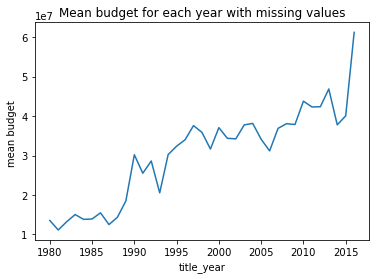

In [218]:
grouped_by_year = movie_df.groupby("title_year").budget.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean budget ")
plt.title("Mean budget for each year with missing values")
plt.show()

Even if the mean of budgets of each year is not zero, it can happens that the budget of some movies is zero (this means that the value was missed and we replaced it with zero)

In [219]:
zero_budget = (movie_df.budget == 0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 150


For each movie we have a rank of its director and its cast. These elements are the ones which influence most the movie's budget. Another feature which influence the cost of a movie is the genre. We will rank every movie considering cast/director and its genre

**cast/director**

In [220]:
# rank for the cast considering its 3 actors rank
fill_budget_df = movie_df[['actor1_rank','actor2_rank','actor3_rank']]

In [221]:
# the protagonist has a bigger weight than others: 50% first actor, 30% second actor, 20% third actor
fill_budget_df['rank_cast'] = fill_budget_df.actor1_rank * 0.5 + fill_budget_df.actor2_rank * 0.30 + fill_budget_df.actor2_rank * 0.2
fill_budget_df.head()

,actor1_rank,actor2_rank,actor3_rank,rank_cast
imdb_id,,,,
tt0035423,6,4,4,5.0
tt0080339,2,3,4,2.5
tt0080453,3,3,4,3.0
tt0080455,3,3,4,3.0
tt0080487,7,3,5,5.0


In [222]:
fill_budget_df = fill_budget_df.drop(columns= ['actor1_rank','actor2_rank','actor3_rank'])
fill_budget_df['director_rank'] = movie_df.director_rank
fill_budget_df.head()

,rank_cast,director_rank
imdb_id,,
tt0035423,5.0,8
tt0080339,2.5,8
tt0080453,3.0,7
tt0080455,3.0,8
tt0080487,5.0,7


**genre**

Some genres requires a bigger investment. We found some articles which proves that (see Report). In particular, the most expensive are
- Action_Adventure
- Sci-Fi_Fantasy
- History_War

Average 65 milion

Then there is
- Animation

Average 60 milion

Others have a mean of 20 milion.

Then we can assign to each movie a rank based on genre average cost:

In [223]:
movie_genres = movie_df[[
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War','Others']]

movie_genres.to_csv('data/data_genre.csv')

movie_genres.head()

,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others
imdb_id,,,,,,,,,,,
tt0035423,0,1,0,0,1,0,1,0,0,0,0
tt0080339,0,1,0,0,0,0,0,0,0,0,0
tt0080453,0,0,0,1,1,0,0,0,1,0,0
tt0080455,0,1,1,0,0,0,0,0,1,0,1
tt0080487,0,1,0,0,0,0,0,0,0,0,1


In [224]:
genre_rank = []

for i in range(len(movie_genres)): #for each movie
    index = movie_genres.index[i]
    rowData = movie_genres.loc[ index , : ] # all genres of one movie
    
    if rowData.Action_Adventure==1 or rowData['Sci-Fi_Fantasy']==1 or rowData.History_War==1 :
        genre_rank.append(1)
    elif rowData.Family_Animation==1 :
        genre_rank.append(round(float(60/65),2))
    else :
        genre_rank.append(round(float(60/65),2))


In [225]:
fill_budget_df['genre_rank'] = genre_rank
fill_budget_df = fill_budget_df.sort_values('director_rank', ascending=False) #sort values

# scale 0-1 also for rank_cast and director_rank
fill_budget_df.rank_cast = fill_budget_df.rank_cast/fill_budget_df.rank_cast.max()
fill_budget_df.director_rank = [round(float(x),2) for x in fill_budget_df.director_rank]
fill_budget_df.director_rank = fill_budget_df.director_rank/fill_budget_df.director_rank.max()


Warning!!!! remember to comment that this is a ranking of importance. it does not mean that the costs are 0.3 0.3 0.3

We suppose each is equally important:

In [226]:
fill_budget_df['rank_for_budget'] = fill_budget_df.mean(axis=1)
fill_budget_df.head()

,rank_cast,director_rank,genre_rank,rank_for_budget
imdb_id,,,,
tt0080684,0.50,1.0,1.00,0.833333
tt2395427,0.55,0.9,1.00,0.816667
tt0428959,0.10,0.9,0.92,0.640000
tt0105695,0.75,0.9,0.92,0.856667
tt0105236,0.55,0.9,0.92,0.790000


In [227]:
fill_budget_df = fill_budget_df.drop(columns= ['rank_cast','director_rank','genre_rank'])
fill_budget_df['budget'] = movie_df.budget
fill_budget_df = fill_budget_df.sort_values('rank_for_budget', ascending=False) #sort values
fill_budget_df.head(20)

,rank_for_budget,budget
imdb_id,,
tt1057500,0.933333,60000000.0
tt0097441,0.900000,18000000.0
tt0118607,0.900000,36000000.0
tt1204975,0.873333,28000000.0
tt0117665,0.873333,44000000.0
tt0203019,0.873333,32000000.0
tt1001526,0.866667,130000000.0
tt0236493,0.866667,34000000.0
tt0102057,0.866667,70000000.0


Now each film has a rank of features which influence the budget. Keep all of them would be too complicate, then we identify a rank of 20 values.


In [228]:
massimo = fill_budget_df.rank_for_budget.max()
fill_budget_df['rank_for_budget_integer'] = [int(x) for x in fill_budget_df.rank_for_budget/massimo*2*10]
fill_budget_df.head(10)

,rank_for_budget,budget,rank_for_budget_integer
imdb_id,,,
tt1057500,0.933333,60000000.0,20
tt0097441,0.900000,18000000.0,19
tt0118607,0.900000,36000000.0,19
tt1204975,0.873333,28000000.0,18
tt0117665,0.873333,44000000.0,18
tt0203019,0.873333,32000000.0,18
tt1001526,0.866667,130000000.0,18
tt0236493,0.866667,34000000.0,18
tt0102057,0.866667,70000000.0,18


In [229]:
# mean of each rank of budget, ignoring movies with missing budget (which would bias the mean)

# ignore zero budget movies
movies_with_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget==0].index)
movies_with_budget_df = movies_with_budget_df.drop(columns='rank_for_budget')
data = movies_with_budget_df.groupby(movies_with_budget_df.rank_for_budget_integer)
data = data.mean()
data.head(20)

,budget
rank_for_budget_integer,
9,1.250000e+07
10,7.665595e+06
11,1.385944e+07
12,1.649391e+07
13,2.410917e+07
14,3.100846e+07
15,4.875897e+07
16,6.420639e+07
17,8.236944e+07


Now for each rank (no movies under rank = 7) we have the mean of its movies. We can assign this value of budget to movies with missing budget

In [230]:
movies_missing_budget_df = fill_budget_df.drop(fill_budget_df[fill_budget_df.budget>0].index)
movies_missing_budget_df = movies_missing_budget_df.drop(columns='rank_for_budget')
movies_missing_budget_df.head()

,budget,rank_for_budget_integer
imdb_id,,
tt0245280,0.0,15
tt0368222,0.0,15
tt1175709,0.0,15
tt1014806,0.0,15
tt0319829,0.0,15


In [231]:
print(f"We check that they are actually {len(movies_missing_budget_df)} movies")

We check that they are actually 150 movies


In [232]:
# fill values
for i in range(len(movies_missing_budget_df)):
    index = movies_missing_budget_df.index[i]
    rowData = movies_missing_budget_df.loc[ index , : ] # all genres of one movie
    rank_movie = int(rowData.rank_for_budget_integer)
    
    budget_movie =  data.loc[ rank_movie , : ].budget

    movie_df.update(
        movie_df.loc[movie_df.index == index, 'budget'].replace(0.0, budget_movie, regex=True)
    )

In [233]:
# we should have filled all zero budget values. check:
zero_budget = (movie_df.budget==0).values
num_zero_budget = zero_budget.sum()
print(f"Number of missed budget values = {num_zero_budget}")

Number of missed budget values = 0


## Fill Missing gross Values

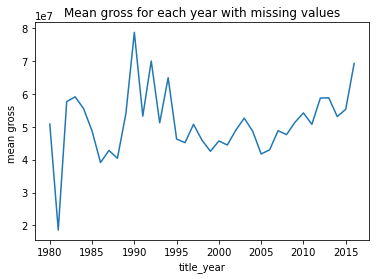

In [234]:
grouped_by_year = movie_df.groupby("title_year").gross.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross ")
plt.title("Mean gross for each year with missing values")
plt.show()

Even if the mean of grosss of each year is not zero, it can happens that the gross of some movies is zero (this means that the value was missed and we replaced it with zero)

In [235]:
zero_gross = (movie_df.gross == 0).values
num_zero_gross = zero_gross.sum()
print(f"Number of missed gross values = {num_zero_gross}")

Number of missed gross values = 263


For each movie we have a rank of its director and its cast. These elements are the ones which influence most the movie's gross. Another feature which influence the cost of a movie is the genre. We will rank every movie considering cast/director and its genre

**cast/director**

In [236]:
# rank for the cast considering its 3 actors rank
fill_gross_df = movie_df[['actor1_rank','actor2_rank','actor3_rank']]

In [237]:
# the protagonist has a bigger weight than others: 50% first actor, 30% second actor, 20% third actor
fill_gross_df['rank_cast'] = fill_gross_df.actor1_rank * 0.5 + fill_gross_df.actor2_rank * 0.30 + fill_gross_df.actor2_rank * 0.2
fill_gross_df.head()

,actor1_rank,actor2_rank,actor3_rank,rank_cast
imdb_id,,,,
tt0035423,6,4,4,5.0
tt0080339,2,3,4,2.5
tt0080453,3,3,4,3.0
tt0080455,3,3,4,3.0
tt0080487,7,3,5,5.0


In [238]:
fill_gross_df = fill_gross_df.drop(columns= ['actor1_rank','actor2_rank','actor3_rank'])
fill_gross_df['director_rank'] = movie_df.director_rank
fill_gross_df.head()

,rank_cast,director_rank
imdb_id,,
tt0035423,5.0,8
tt0080339,2.5,8
tt0080453,3.0,7
tt0080455,3.0,8
tt0080487,5.0,7


**genre**

Some genres requires a bigger investment. We found some articles which proves that (see Report). In particular, the most expensive are
- Action_Adventure
- Sci-Fi_Fantasy
- History_War

Average 65 milion

Then there is
- Animation

Average 60 milion

Others have a mean of 20 milion.

Then we can assign to each movie a rank based on genre average cost:

In [239]:
movie_genres = movie_df[[
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War','Others']]

movie_genres.to_csv('data/data_genre.csv')

movie_genres.head()

,Biography,Comedy,Crime,Drama,Romance,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others
imdb_id,,,,,,,,,,,
tt0035423,0,1,0,0,1,0,1,0,0,0,0
tt0080339,0,1,0,0,0,0,0,0,0,0,0
tt0080453,0,0,0,1,1,0,0,0,1,0,0
tt0080455,0,1,1,0,0,0,0,0,1,0,1
tt0080487,0,1,0,0,0,0,0,0,0,0,1


In [240]:
genre_rank = []

for i in range(len(movie_genres)): #for each movie
    index = movie_genres.index[i]
    rowData = movie_genres.loc[ index , : ] # all genres of one movie
    
    if rowData.Action_Adventure==1 or rowData['Sci-Fi_Fantasy']==1 or rowData.History_War==1 :
        genre_rank.append(1)
    elif rowData.Family_Animation==1 :
        genre_rank.append(round(float(60/65),2))
    else :
        genre_rank.append(round(float(60/65),2))


In [241]:
fill_gross_df['genre_rank'] = genre_rank
fill_gross_df = fill_gross_df.sort_values('director_rank', ascending=False) #sort values

# scale 0-1 also for rank_cast and director_rank
fill_gross_df.rank_cast = fill_gross_df.rank_cast/fill_gross_df.rank_cast.max()
fill_gross_df.director_rank = [round(float(x),2) for x in fill_gross_df.director_rank]
fill_gross_df.director_rank = fill_gross_df.director_rank/fill_gross_df.director_rank.max()


Warning!!!! remember to comment that this is a ranking of importance. it does not mean that the costs are 0.3 0.3 0.3

We suppose each is equally important:

In [242]:
fill_gross_df['rank_for_gross'] = fill_gross_df.mean(axis=1)
fill_gross_df.head()

,rank_cast,director_rank,genre_rank,rank_for_gross
imdb_id,,,,
tt0080684,0.50,1.0,1.00,0.833333
tt2395427,0.55,0.9,1.00,0.816667
tt0428959,0.10,0.9,0.92,0.640000
tt0105695,0.75,0.9,0.92,0.856667
tt0105236,0.55,0.9,0.92,0.790000


In [243]:
fill_gross_df = fill_gross_df.drop(columns= ['rank_cast','director_rank','genre_rank'])
fill_gross_df['gross'] = movie_df.gross
fill_gross_df = fill_gross_df.sort_values('rank_for_gross', ascending=False) #sort values
fill_gross_df.head(20)

,rank_for_gross,gross
imdb_id,,
tt1057500,0.933333,37479778.0
tt0097441,0.900000,26830000.0
tt0118607,0.900000,44175394.0
tt1204975,0.873333,63910583.0
tt0117665,0.873333,53300852.0
tt0203019,0.873333,48814909.0
tt1001526,0.866667,148337537.0
tt0236493,0.866667,66808615.0
tt0102057,0.866667,119654900.0


Now each film has a rank of features which influence the gross. Keep all of them would be too complicate, then we identify a rank of 20 values.


In [244]:
massimo = fill_gross_df.rank_for_gross.max()
fill_gross_df['rank_for_gross_integer'] = [int(x) for x in fill_gross_df.rank_for_gross/massimo*2*10]
fill_gross_df.head(10)

,rank_for_gross,gross,rank_for_gross_integer
imdb_id,,,
tt1057500,0.933333,37479778.0,20
tt0097441,0.900000,26830000.0,19
tt0118607,0.900000,44175394.0,19
tt1204975,0.873333,63910583.0,18
tt0117665,0.873333,53300852.0,18
tt0203019,0.873333,48814909.0,18
tt1001526,0.866667,148337537.0,18
tt0236493,0.866667,66808615.0,18
tt0102057,0.866667,119654900.0,18


In [245]:
# mean of each rank of gross, ignoring movies with missing gross (which would bias the mean)

# ignore zero gross movies
movies_with_gross_df = fill_gross_df.drop(fill_gross_df[fill_gross_df.gross==0].index)
movies_with_gross_df = movies_with_gross_df.drop(columns='rank_for_gross')
data = movies_with_gross_df.groupby(movies_with_gross_df.rank_for_gross_integer)
data = data.mean()
data.head(20)

,gross
rank_for_gross_integer,
9,4.273372e+06
10,1.108432e+07
11,1.956380e+07
12,2.245615e+07
13,3.395089e+07
14,4.298772e+07
15,6.845483e+07
16,9.081291e+07
17,1.307903e+08


Now for each rank (no movies under rank = 7) we have the mean of its movies. We can assign this value of gross to movies with missing gross

In [246]:
movies_missing_gross_df = fill_gross_df.drop(fill_gross_df[fill_gross_df.gross>0].index)
movies_missing_gross_df = movies_missing_gross_df.drop(columns='rank_for_gross')
movies_missing_gross_df.head()

,gross,rank_for_gross_integer
imdb_id,,
tt3838992,0.0,17
tt2231253,0.0,16
tt1137470,0.0,15
tt2479478,0.0,15
tt1014806,0.0,15


In [247]:
# fill values
for i in range(len(movies_missing_gross_df)):
    index = movies_missing_gross_df.index[i]
    rowData = movies_missing_gross_df.loc[ index , : ] # all genres of one movie
    rank_movie = int(rowData.rank_for_gross_integer)
    
    gross_movie =  data.loc[ rank_movie , : ].gross

    movie_df.update(
        movie_df.loc[movie_df.index == index, 'gross'].replace(0.0, gross_movie, regex=True)
    )

In [248]:
# we should have filled all zero gross values. check:
zero_gross = (movie_df.gross==0).values
num_zero_gross = zero_gross.sum()
print(f"Number of missed gross values = {num_zero_gross}")

Number of missed gross values = 0


# Exploratory Data Analysis (EDA)

- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis
- Keywords Analysis


## I. Univariate Analysis

### 1. Some high-level observations

In [249]:
movie_df.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Mystery_Thriller_Horror,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3.333000e+03,3.333000e+03,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,150.183318,107.310231,815.722472,764.633963,7771.224722,5.295294e+07,9.545525e+04,11552.825083,1.418242,299.567957,...,0.348935,0.236724,0.120612,0.321632,0.042304,0.138314,6.847585,4.071407,3.577258,4.297930
std,123.862460,21.044636,3166.240978,1850.481481,16969.217600,6.833871e+07,1.500564e+05,20372.189235,2.109472,395.436377,...,0.476705,0.425135,0.325725,0.467173,0.201313,0.345281,1.153648,1.950852,1.342061,1.480886
min,1.000000,14.000000,0.000000,0.000000,0.000000,7.030000e+02,5.000000e+00,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,60.000000,94.000000,9.000000,215.000000,756.000000,1.108432e+07,1.255900e+04,2014.000000,0.000000,83.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,3.000000,3.000000,3.000000
50%,121.000000,103.000000,53.000000,452.000000,1000.000000,3.270109e+07,4.374300e+04,4043.000000,1.000000,180.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,3.000000,3.000000,4.000000
75%,206.000000,117.000000,212.000000,700.000000,12000.000000,6.820819e+07,1.121750e+05,15800.000000,2.000000,362.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.000000,6.000000,4.000000,5.000000
max,813.000000,330.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,4667.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000


In [250]:
movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget

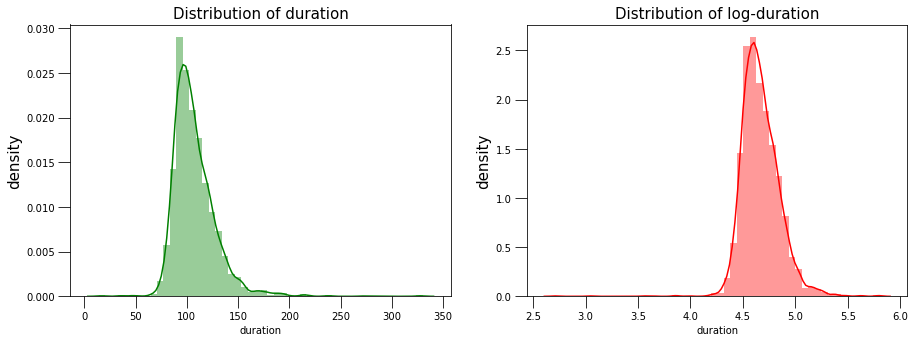

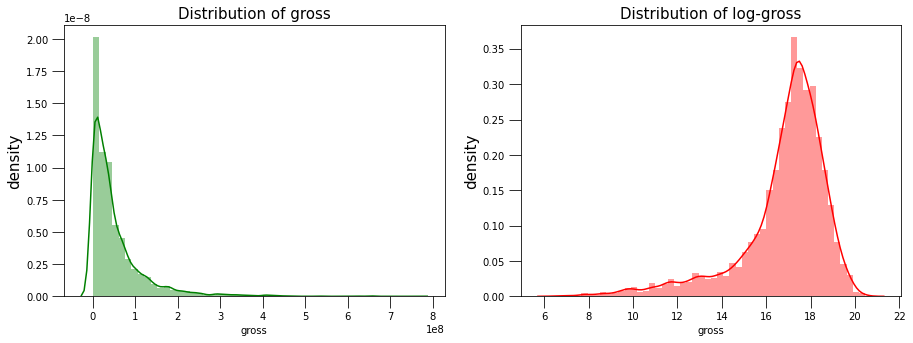

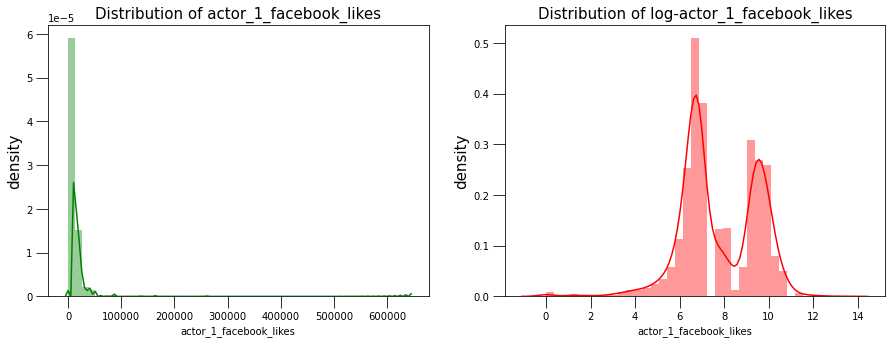

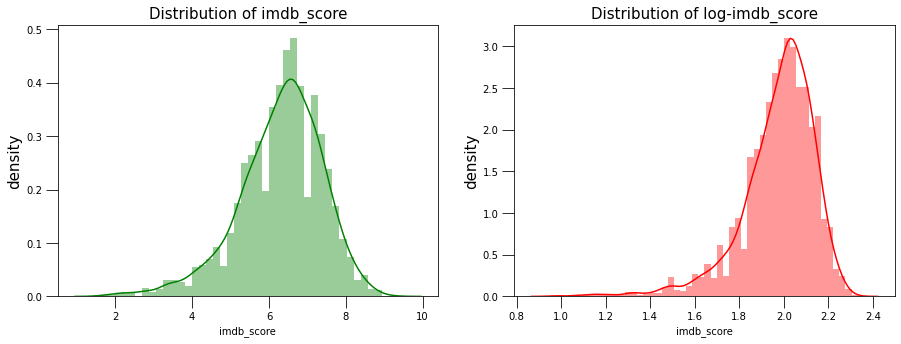

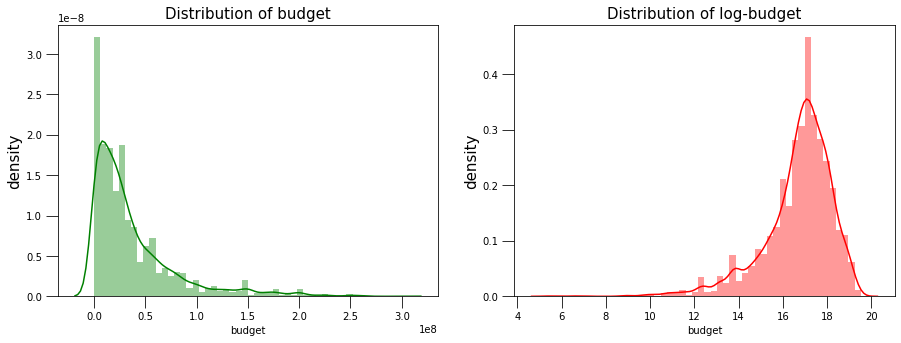

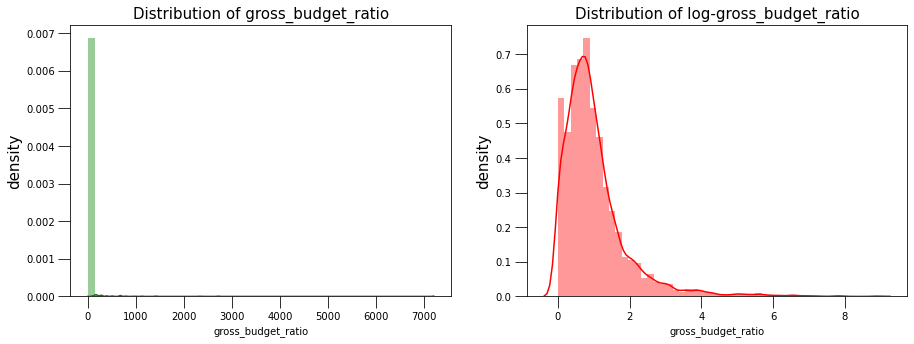

In [251]:
for col in ["duration", "gross", "actor_1_facebook_likes","imdb_score","budget","gross_budget_ratio"]:
    _, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
    sns.distplot(movie_df[col].fillna(0),color='g', ax=ax1)
    sns.distplot(np.log(movie_df[col].fillna(0) + 1), color="r", ax=ax2)
    for ax in (ax1, ax2):
        ax.tick_params(size=12)
        ax.set_ylabel("density", size=15)
    ax1.set_title(f"Distribution of {col}", size=15)
    ax2.set_title(f"Distribution of log-{col}", size=15)

In [252]:
grossde=movie_df['gross'].describe()
budgetde=movie_df['budget'].describe()
ratiogb=movie_df['gross_budget_ratio'].describe()
profitde=(movie_df['gross']-movie_df['budget']).describe()
summary = pd.DataFrame([grossde,budgetde,profitde,ratiogb]).T
summary.columns.values[2] = "profits"
summary#summary statistics of relevant variables

,gross,budget,profits,gross_budget_ratio
count,3.333000e+03,3.333000e+03,3.333000e+03,3333.000000
mean,5.295294e+07,3.714527e+07,1.580767e+07,10.605091
std,6.833871e+07,4.184403e+07,5.163919e+07,147.605076
min,7.030000e+02,2.180000e+02,-1.906413e+08,0.000118
25%,1.108432e+07,1.000000e+07,-8.930592e+06,0.566616
50%,3.270109e+07,2.410917e+07,4.806295e+06,1.256179
75%,6.820819e+07,5.000000e+07,2.975089e+07,2.560000
max,7.605058e+08,3.000000e+08,5.235058e+08,7194.485533


In [253]:
movie_df['imdb_score'].describe()


count    3333.000000
mean        6.300300
std         1.091163
min         1.600000
25%         5.700000
50%         6.400000
75%         7.100000
max         9.300000
Name: imdb_score, dtype: float64

In [254]:
movie_df['cast_total_facebook_likes'].describe()

count      3333.000000
mean      11552.825083
std       20372.189235
min           0.000000
25%        2014.000000
50%        4043.000000
75%       15800.000000
max      656730.000000
Name: cast_total_facebook_likes, dtype: float64

we can see that distribution of budget and gross of movies are not so explanatory. This is due to the fact the the data sets includes both boxoffice movies and documentaries that have a significant difference in marketing and financial needs.
So it might be interesting to look at the number of movies by genre. 


In [255]:
### using econded_genres
encoded_genres.mean()

Biography                  0.050105
Comedy                     0.422142
Crime                      0.180018
Drama                      0.477648
Romance                    0.219922
Mystery_Thriller_Horror    0.348935
Sci-Fi_Fantasy             0.236724
Family_Animation           0.120612
Action_Adventure           0.321632
History_War                0.042304
Others                     0.138314
dtype: float64

Here we see that, half of the movies in the dataset have genre of drama. Comedy, (Mystery|Thriller|Horror), (Action|Adventure) follows the drama respectively.

In [256]:
print ("Percentages of the possible values for each single object \n")
movie_data = movie_df.select_dtypes(include=['O'])
for c in ['director_name','actor_1_name']:
    print ("Top 5 (Based on number of movie) %s" % c)
    print (movie_df[c].value_counts(normalize=True).head())
    print("\n")

Percentages of the possible values for each single object 

Top 5 (Based on number of movie) director_name
Steven Spielberg    0.006301
Clint Eastwood      0.005701
Spike Lee           0.004800
Martin Scorsese     0.004800
Tim Burton          0.004200
Name: director_name, dtype: float64


Top 5 (Based on number of movie) actor_1_name
Robert De Niro       0.011101
Johnny Depp          0.009301
J.K. Simmons         0.008701
Denzel Washington    0.008401
Nicolas Cage         0.008401
Name: actor_1_name, dtype: float64




Here, we see that Steven Spielberg has the highest number of movies directed and Robert De Niro was the main actor at the movies more than all other actors.

SP 500 for comparison with the economy

Text(0, 0.5, 'SP500')

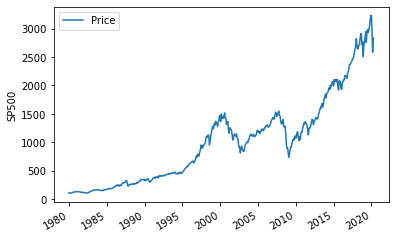

In [257]:
sp500 = (pd.read_csv(r'data/SeP500.csv')).iloc[::-1]
index = pd.period_range(start="01-01-1980", end="04-01-2020", freq="M")
sp500.index=index
sp500['Price'] = sp500['Price'].str.replace(',', '')
sp500['Price'] = sp500['Price'].astype(float)
sp500price=sp500.Price.resample("A").mean()

sp500.plot(x_compat=True)
plt.ylabel("SP500")

Interest rate as index of required return

Text(0, 0.5, 'FED interest rate')

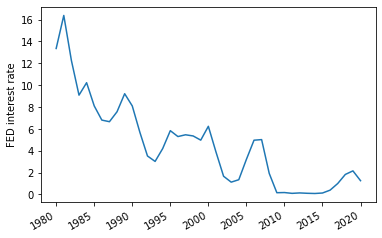

In [258]:
fed = (pd.read_csv(r'data/fed.csv'))#.iloc[::-1]
index = pd.period_range(start="01-01-1980", end="03-01-2020", freq="M")
fed.index=index

fed['FEDFUNDS'] = fed['FEDFUNDS'].astype(float)
fedrate=fed.FEDFUNDS.resample("A").mean()
fedrate.plot(x_compat=True)
plt.ylabel("FED interest rate")

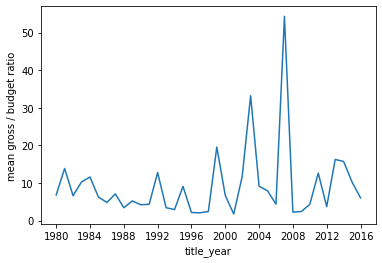

In [259]:
movie_df["gross_budget_ratio"] = movie_df.gross / movie_df.budget
grouped_by_year = movie_df.groupby("title_year").gross_budget_ratio.mean()
sns.lineplot(grouped_by_year.index, grouped_by_year)
plt.ylabel("mean gross / budget ratio")
plt.xticks(np.arange(min(grouped_by_year.index), max(grouped_by_year.index)+1, 4))
plt.show()


In [260]:
ContentRating=movie_df.groupby('content_rating')['content_rating'].count()

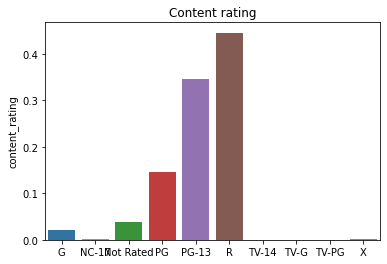

In [261]:
CRDF = ContentRating.to_frame()
units = CRDF.content_rating/CRDF.content_rating.sum()
bars = CRDF.index
names = np.arange(len(bars))
sns.barplot(names, units)
plt.xticks(names, bars)
plt.title("Content rating")
plt.show()

As can be seen above, half of the movies can be seen by people bigger than 13 years old (PG, PG-13, G). And remaining half can be watched by people above age of 17.

### 2. Let's look at films from a prominent director

In [262]:
director = "Christopher Nolan" # change this variable if you want to look into another director
director_films = movie_df.query(f"director_name == '{director}'").sort_values(by="title_year")
director_films.columns
genres_col={'Biography', 'Comedy', 'Crime', 'Drama', 'Romance',
       'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy', 'Family_Animation',
       'Action_Adventure', 'History_War', 'Others'}

Guys there is a function which do the one hot encoding :)

In [263]:
##using genres_col
sums=director_films.sum()
print("Genres' counter\n")
for i in genres_col:
    print('Group ',i,'=',sums[i])
    
print("\n")
print("Number of films per year \n")
print(director_films.title_year.value_counts())
print("\n")

Genres' counter

Group  History_War = 0
Group  Sci-Fi_Fantasy = 3
Group  Crime = 1
Group  Family_Animation = 0
Group  Biography = 0
Group  Comedy = 0
Group  Action_Adventure = 5
Group  Mystery_Thriller_Horror = 6
Group  Others = 0
Group  Romance = 0
Group  Drama = 4


Number of films per year 

2014.0    1
2012.0    1
2010.0    1
2008.0    1
2006.0    1
2005.0    1
2002.0    1
2000.0    1
Name: title_year, dtype: int64




##### profitability - budget-gross ratio

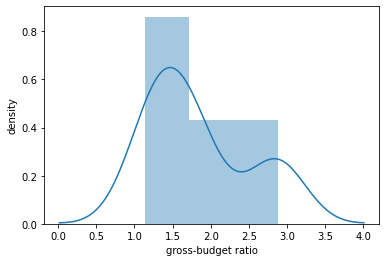

In [264]:
plt.figure()
sns.distplot(director_films["gross_budget_ratio"])
plt.xlabel("gross-budget ratio")
plt.ylabel("density")
plt.show()

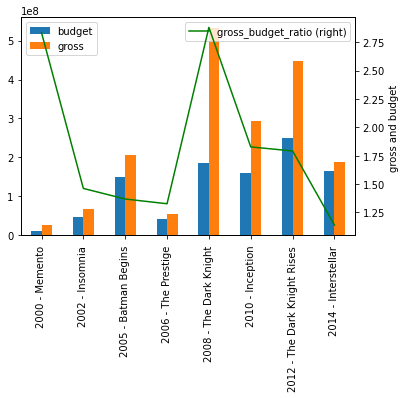

In [265]:
director_titles_years = director_films["title_year"].map(int).map(str) + " - " + director_films["movie_title"].map(str)  
graph=director_films["budget"].to_frame()
graph['gross_budget_ratio']=director_films["gross_budget_ratio"]
graph['gross']=director_films["gross"]
graph.index=director_titles_years

ax = plt.subplot(111)
ax2= ax.twinx()
graph.gross_budget_ratio.plot(ax=ax2, style='g-', secondary_y=True, legend='ratio')
plt.ylabel("gross-budget ratio")
graph.plot(ax=ax,y=["budget", "gross"], kind="bar")
plt.ylabel("gross and budget ")
ax.tick_params(axis='x', rotation=90)
leg = ax.get_legend()
leg.remove()        # remove it from ax
ax2.add_artist(leg) # add it to ax2
leg._set_loc(2)
plt.show()


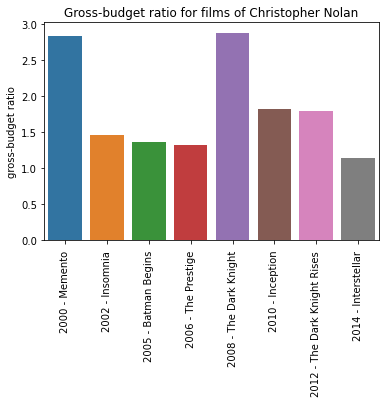

In [266]:


sns.barplot(director_titles_years, director_films["gross_budget_ratio"])
plt.xticks(rotation=90)
plt.ylabel("gross-budget ratio")
plt.title(f"Gross-budget ratio for films of {director}")
plt.show()

In [267]:
director_films

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,Sci-Fi_Fantasy,Family_Animation,Action_Adventure,History_War,Others,director_rank,actor1_rank,actor2_rank,actor3_rank,gross_budget_ratio
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0209144,Christopher Nolan,274.0,113.0,22000.0,379.0,Thomas Lennon,716.0,25530884.0,Mystery|Thriller,Callum Rennie,...,0,0,0,0,0,9,3,4,4,2.836765
tt0278504,Christopher Nolan,185.0,118.0,22000.0,319.0,Maura Tierney,14000.0,67263182.0,Drama|Mystery|Thriller,Al Pacino,...,0,0,0,0,0,9,6,4,4,1.462243
tt0372784,Christopher Nolan,478.0,128.0,22000.0,11000.0,Liam Neeson,23000.0,205343774.0,Action|Adventure,Christian Bale,...,0,0,1,0,0,9,6,5,6,1.368958
tt0482571,Christopher Nolan,341.0,130.0,22000.0,19000.0,Hugh Jackman,23000.0,53082743.0,Drama|Mystery|Sci-Fi|Thriller,Christian Bale,...,1,0,0,0,0,9,6,5,7,1.327069
tt0468569,Christopher Nolan,645.0,152.0,22000.0,11000.0,Heath Ledger,23000.0,533316061.0,Action|Crime|Drama|Thriller,Christian Bale,...,0,0,1,0,0,9,6,6,6,2.882790
tt1375666,Christopher Nolan,642.0,148.0,22000.0,23000.0,Tom Hardy,29000.0,292568851.0,Action|Adventure|Sci-Fi|Thriller,Leonardo DiCaprio,...,1,0,1,0,0,9,7,5,7,1.828555
tt1345836,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,0,0,1,0,0,9,4,6,7,1.792523
tt0816692,Christopher Nolan,712.0,169.0,22000.0,6000.0,Anne Hathaway,11000.0,187991439.0,Adventure|Drama|Sci-Fi,Matthew McConaughey,...,1,0,1,0,0,9,6,5,5,1.139342


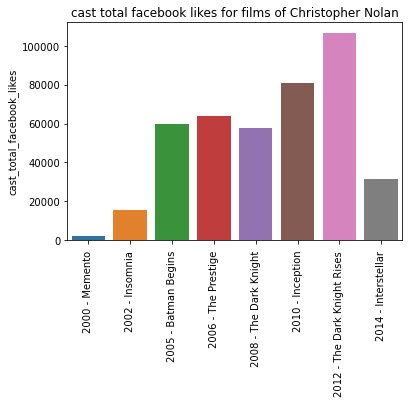

In [268]:
sns.barplot(director_titles_years, director_films.cast_total_facebook_likes)
plt.xticks(rotation=90)
plt.ylabel("cast_total_facebook_likes")
plt.title(f"cast total facebook likes for films of {director}")
plt.show()

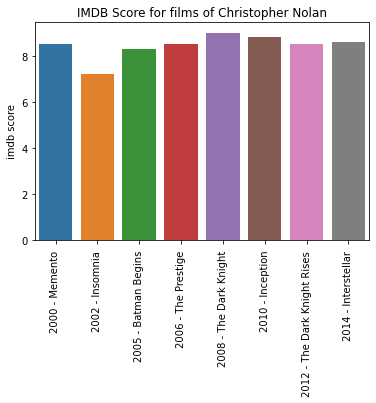

In [269]:
sns.barplot(director_titles_years, director_films.imdb_score)
plt.xticks(rotation=90)
plt.ylabel("imdb score")
plt.title(f"IMDB Score for films of {director}")
plt.show()

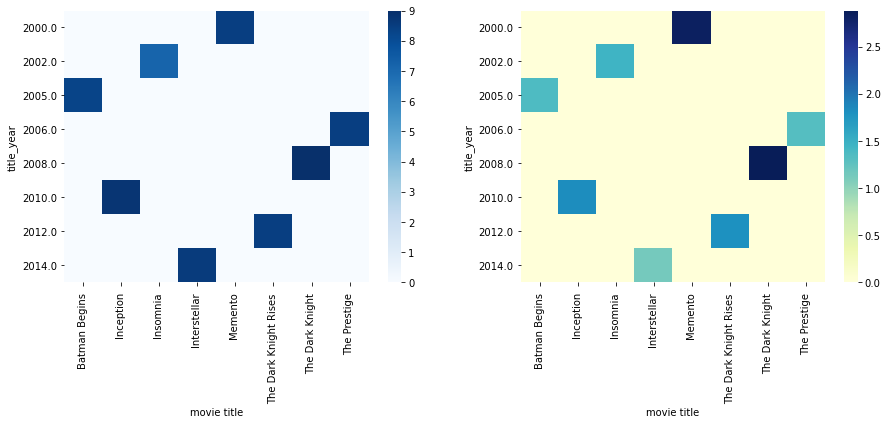

In [270]:
# heatmap 
_, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2, nrows=1)
director_film_year_score = pd.pivot_table(data=director_films, values=["imdb_score"], index=["title_year"],
                                          columns=["movie_title"]).fillna(0)

sns.heatmap(director_film_year_score, cmap="Blues", ax=ax1)
ax1.set_xticklabels(list(director_film_year_score.columns.levels[1]))
ax1.set_xlabel("movie title")

director_film_year_bgr = pd.pivot_table(data=director_films, values=["gross_budget_ratio"], index=["title_year"],
                                          columns=["movie_title"]).fillna(0)
sns.heatmap(director_film_year_bgr, cmap="YlGnBu", ax=ax2)
ax2.set_xticklabels(list(director_film_year_bgr.columns.levels[1]))
ax2.set_xlabel("movie title")

plt.show()
# I don't think we need this part, it gives the same information as above

## II. Bi/Multi-variate Analysis

With this analysis we want to find out the relationship between a factor with the two indicators of a film's success: profitability and IMDB score.



### 1. Relationship between profitability and IMDB score

In [271]:
movies_with_valid_profit = movie_df[movie_df.gross_budget_ratio<=20]

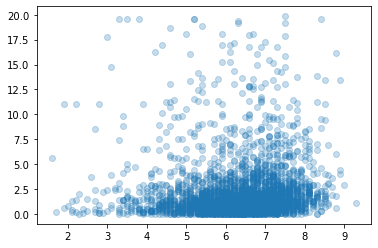

In [272]:
plt.scatter(movies_with_valid_profit.imdb_score, movies_with_valid_profit.gross_budget_ratio, alpha=.25)
plt.show()

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

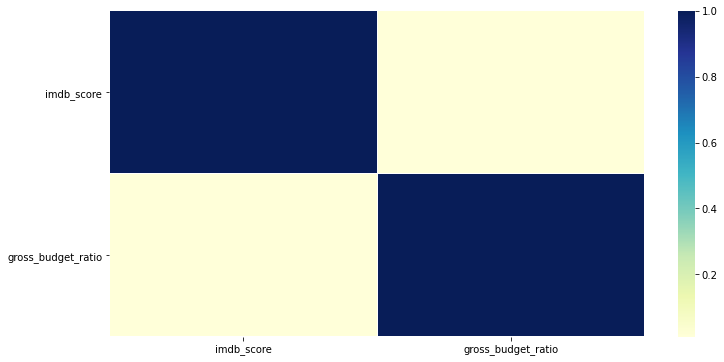

In [273]:
# again, don't see much influence here
pivot=movie_df[['imdb_score',"gross_budget_ratio"]]
pivot=pivot[pivot.gross_budget_ratio<=20]
corp = pivot.apply(lambda x: pd.factorize(x)[0])#scaling 
corp=corp.corr()
plt.figure(figsize=(12, 6))
ax = sns.heatmap(corp, xticklabels=corp.columns, yticklabels=corp.columns, 
                 linewidths=.2, cmap="YlGnBu")
plt.yticks(rotation=0)  

 

In [274]:
def cor(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 15, xycoords = ax.transAxes)
    

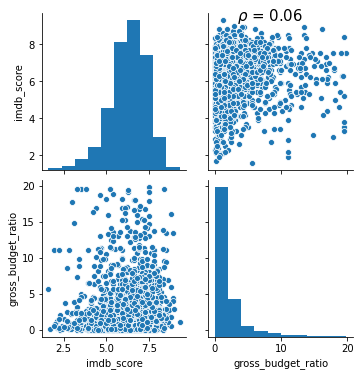

In [275]:
grid=sns.pairplot(data=movie_df[movie_df.gross_budget_ratio<=20], vars=["imdb_score", "gross_budget_ratio"])
grid = grid.map_upper(cor)

If we remove the outliers of profitability ratio, we see that to have a profitability ratio higher than 5, a movie must have an IMDb score of 4 and above.

In [276]:
movies_with_imdb_classmean=[]
movies_with_imdb_classmean.append(movie_df[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].gross_budget_ratio.mean())
movies_with_imdb_classmean.append(movie_df[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].gross_budget_ratio.mean()) 
movies_with_imdb_classmean.append(movie_df[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].gross_budget_ratio.mean()) 

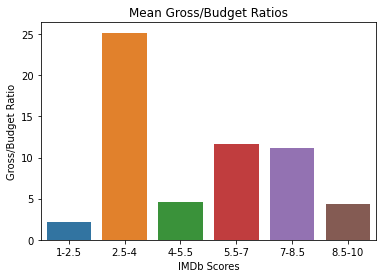

In [277]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean)
plt.xticks(rotation=0)
plt.ylabel("Gross/Budget Ratio")
plt.xlabel('IMDb Scores')
plt.title(f"Mean Gross/Budget Ratios")
plt.show()

In [278]:
movies_with_gb_classmean=[]
movies_with_gb_classmean.append(movie_df[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].imdb_score.mean())
movies_with_gb_classmean.append(movie_df[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].imdb_score.mean()) 
movies_with_gb_classmean.append(movie_df[(20<movie_df.gross_budget_ratio)].imdb_score.mean())

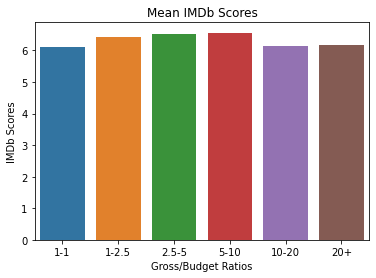

In [279]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean)
plt.xticks(rotation=0)
plt.ylabel("IMDb Scores")
plt.xlabel('Gross/Budget Ratios')
plt.title(f"Mean IMDb Scores")
plt.show()

### 2. Influence of Social Media?

In [280]:
movie_df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Romance', 'Mystery_Thriller_Horror', 'Sci-Fi_Fantasy',
       'Family_Animation', 'Action_Adventure', 'History_War', 'Others',
       'director_rank', 'actor1_rank', 'actor2_rank', 'actor3_rank',
       'gross_budget_ratio'],
      dtype='object')

In [281]:
datapi=movie_df[["cast_total_facebook_likes", "movie_facebook_likes", "director_facebook_likes",'imdb_score',"gross_budget_ratio","title_year"]]
datapi=datapi.loc[datapi.title_year>2009]
datapi=datapi.drop("title_year", axis=1)
datapi = datapi.apply(lambda x: pd.factorize(x)[0])
core=datapi.corr()


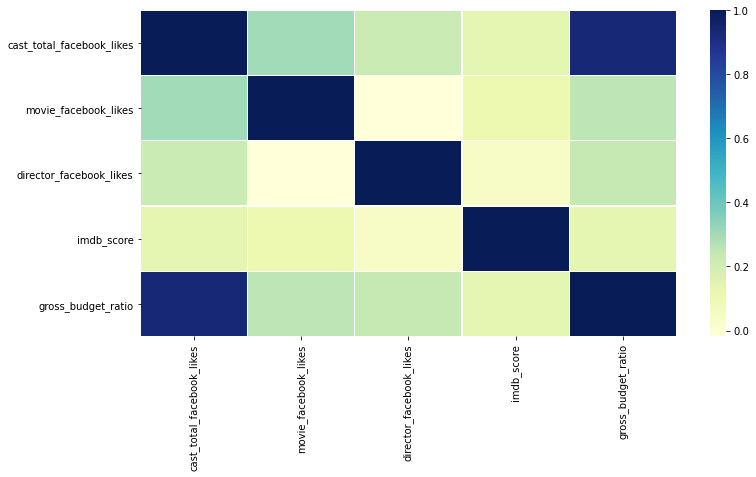

In [282]:
plt.figure(figsize=(12, 6))
ax = sns.heatmap(core, xticklabels=core.columns, yticklabels=core.columns, 
                 linewidths=.2, cmap="YlGnBu")

Here, we realize that IMDb score and movie facebook likes might be related. Hence, we analyze these two variables.

In [283]:
movies_with_imdb_classmean2=[]
movies_with_imdb_classmean2.append(datapi[(1<movie_df.imdb_score) & (movie_df.imdb_score<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(2.5<movie_df.imdb_score) & (movie_df.imdb_score<=4) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(4<movie_df.imdb_score) & (movie_df.imdb_score<=5.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(5.5<movie_df.imdb_score) & (movie_df.imdb_score<=7) ].cast_total_facebook_likes.mean())
movies_with_imdb_classmean2.append(datapi[(7<movie_df.imdb_score) & (movie_df.imdb_score<=8.5) ].cast_total_facebook_likes.mean()) 
movies_with_imdb_classmean2.append(datapi[(8.5<movie_df.imdb_score) & (movie_df.imdb_score<=10) ].cast_total_facebook_likes.mean()) 

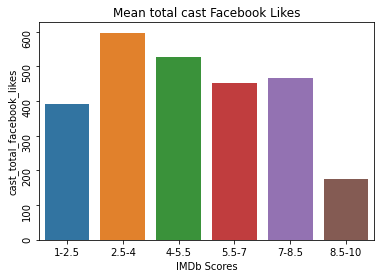

In [284]:
Limits =['1-2.5','2.5-4','4-5.5','5.5-7','7-8.5','8.5-10']
sns.barplot(Limits, movies_with_imdb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast_total_facebook_likes")
plt.xlabel('IMDb Scores')
plt.title(f"Mean total cast Facebook Likes")
plt.yticks(rotation=90)
plt.show()

In [285]:

movies_with_gb_classmean2=[]
movies_with_gb_classmean2.append(datapi[(0<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=1) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(1<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=2.5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(2.5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=5) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(5<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=10) ].cast_total_facebook_likes.mean())
movies_with_gb_classmean2.append(datapi[(10<movie_df.gross_budget_ratio) & (movie_df.gross_budget_ratio<=20) ].cast_total_facebook_likes.mean()) 
movies_with_gb_classmean2.append(datapi[(20<movie_df.gross_budget_ratio)].cast_total_facebook_likes.mean())

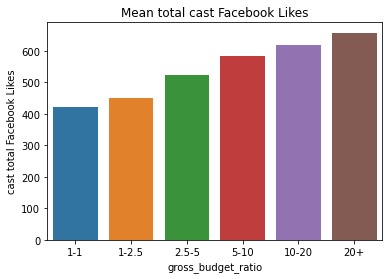

In [286]:
Limits =['1-1','1-2.5','2.5-5','5-10','10-20','20+']
sns.barplot(Limits, movies_with_gb_classmean2)
plt.xticks(rotation=0)
plt.ylabel("cast total Facebook Likes")
plt.xlabel('gross_budget_ratio')
plt.title(f"Mean total cast Facebook Likes")
plt.show()


### 3. Effect of Genre on Profitability and IMDb Score

### I. Profitability

In [287]:
##using genres_col,
GenreProf = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War','Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].mean()
GenreNumber = movie_df[movie_df.gross_budget_ratio<=20].groupby(['Action_Adventure',
 'Biography','Comedy','Crime','Drama','Family_Animation','History_War', 'Mystery_Thriller_Horror','Others','Romance','Sci-Fi_Fantasy'])['gross_budget_ratio'].count()

In [288]:
Genrestable = GenreProf.to_frame()
Genrestable1 = Genrestable.reset_index()
Genrestable2 = Genrestable1.sort_values(by=['gross_budget_ratio'],ascending=False)

In [289]:
GenreNumber1 = GenreNumber.reset_index()

GenreNumber2 = GenreNumber1.reindex(Genrestable2.index)

In [290]:
Genrestable2

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
203,1,0,0,1,0,1,0,1,0,0,1,19.558523
162,1,0,0,0,0,0,1,0,1,0,0,16.975443
272,1,1,0,0,1,0,0,0,1,0,0,10.732835
191,1,0,0,0,1,1,0,0,1,0,0,10.372598
29,0,0,0,0,1,0,0,1,1,1,1,8.982458
...,...,...,...,...,...,...,...,...,...,...,...,...
244,1,0,1,0,1,0,1,1,0,1,0,0.035067
278,1,1,0,1,1,0,0,0,0,0,0,0.017919
49,0,0,0,1,0,0,1,1,0,0,0,0.013017
96,0,0,1,0,1,0,1,0,0,0,0,0.012206


In [291]:
GenreNumber2

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
203,1,0,0,1,0,1,0,1,0,0,1,1
162,1,0,0,0,0,0,1,0,1,0,0,1
272,1,1,0,0,1,0,0,0,1,0,0,1
191,1,0,0,0,1,1,0,0,1,0,0,2
29,0,0,0,0,1,0,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
244,1,0,1,0,1,0,1,1,0,1,0,1
278,1,1,0,1,1,0,0,0,0,0,0,1
49,0,0,0,1,0,0,1,1,0,0,0,1
96,0,0,1,0,1,0,1,0,0,0,0,1


From the 2 dataframe above, we see that 3 movies with genres Drama,Crime and Romance together achieved 5.3 gross/budget ratio. However, since number of movies are low it might be due to some outlier. Hence, we try to analyze highest number of movies with the same genre combination.

In [292]:
GenreNumber3=GenreNumber2.sort_values(by=['gross_budget_ratio'],ascending=False)
Genrestable3 = Genrestable2.reindex(GenreNumber3.index)

In [293]:
GenreNumber3

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
62,0,0,1,0,0,0,0,0,0,0,0,162
3,0,0,0,0,0,0,0,1,0,0,0,145
88,0,0,1,0,1,0,0,0,0,1,0,138
86,0,0,1,0,1,0,0,0,0,0,0,136
16,0,0,0,0,1,0,0,0,0,0,0,132
...,...,...,...,...,...,...,...,...,...,...,...,...
171,1,0,0,0,0,1,1,0,1,0,1,1
45,0,0,0,1,0,0,0,1,0,0,1,1
60,0,0,0,1,1,0,1,0,0,1,0,1
224,1,0,1,0,0,0,0,1,1,1,0,1


In [294]:
Genrestable3

,Action_Adventure,Biography,Comedy,Crime,Drama,Family_Animation,History_War,Mystery_Thriller_Horror,Others,Romance,Sci-Fi_Fantasy,gross_budget_ratio
62,0,0,1,0,0,0,0,0,0,0,0,2.137785
3,0,0,0,0,0,0,0,1,0,0,0,4.644743
88,0,0,1,0,1,0,0,0,0,1,0,2.557707
86,0,0,1,0,1,0,0,0,0,0,0,2.250547
16,0,0,0,0,1,0,0,0,0,0,0,2.015413
...,...,...,...,...,...,...,...,...,...,...,...,...
171,1,0,0,0,0,1,1,0,1,0,1,1.340204
45,0,0,0,1,0,0,0,1,0,0,1,1.355465
60,0,0,0,1,1,0,1,0,0,1,0,1.369698
224,1,0,1,0,0,0,0,1,1,1,0,1.442632


Here, we see that at the top 4 places all combinations have more than 140 movies. Hence, we can comment more confidently. We see that all of the for segments include Drama in it and all of them has gross/budget ratio of 2 which is a nice number for film makers. By looking at the data, we can say that:
1. Drama + Others ~ 1.7
2. Drama + Comedy + Romance ~2.4
3. Drama Only ~ 1.8
4. Drama + Comedy ~2

Hence, it might be logical to make a drama movie with some comedy and romance in it.

## Keyword Analysis

In [295]:
# words_df is a ataframe which contains what we need for the keyword analysis
words_df = movie_df[['plot_keywords','budget', 'gross']] 

# a list with all the plot keywords for each movie
words = words_df.plot_keywords
words = [x.split("|") for x in words]


for i in range(len(words_df.plot_keywords)): # for each movie
    
    words[i] = [x.split() for x in words[i]] # splitted words of that movie 
    w = []
    
    # delete sub list in order to have one list for each movie and one one list for each word for each movie
    for j in range(len(words[i])):
        for k in range(len(words[i][j])):
            if len(words[i][j][k])>2 and ' ' not in words[i][j][k]:
                w.append(words[i][j][k])
    
    words[i] = w
    
    # delete duplicates
    words[i] = list(OrderedDict.fromkeys(words[i])) 

In [296]:
words_df.plot_keywords = words
words_df.head()

,plot_keywords,budget,gross
imdb_id,,,
tt0035423,"[bridge, brooklyn, falling, down, elevator, sh...",48000000.0,47095453.0
tt0080339,"[air, traffic, controller, airplane, airport, ...",3500000.0,83400000.0
tt0080453,"[coming, age, island, poison, teenage, boy, girl]",4500000.0,58853106.0
tt0080455,"[band, catholic, money, parolee, prison]",27000000.0,54200000.0
tt0080487,"[caddy, country, club, golf, course, gopher, n...",6000000.0,39800000.0


In [297]:
# we need the genre of each movie

movie_genre_df = pd.read_csv(r'data/data_genre.csv')
movie_genre_df = movie_genre_df.set_index('imdb_id')

words_df = words_df.merge(movie_genre_df, how='left', left_index=True, right_index=True)

In [298]:
genres = [
    'Biography','Comedy','Crime','Drama','Romance','Mystery_Thriller_Horror',
    'Sci-Fi_Fantasy','Family_Animation','Action_Adventure','History_War', 'Others']

for genre in genres: # for each genre
    
    print(genre)
    
    column = words_df[genre]
    
    words_genre_df = words_df[column==1]
    
    words_genre = []
    
    num_film_word = [0]*len(words_genre_df) # num of movies of that genre in which that word appears
    
    # delete sub list
    for j in range(len(words_genre_df)):
        for k in range(len(words_genre_df.plot_keywords[j])):
            if len(words_genre_df.plot_keywords[j][k])>2 and ' ' not in words_genre_df.plot_keywords[j][k]:
                words_genre.append(words_genre_df.plot_keywords[j][k])
    
    # list of all words of this genre:
    words_genre = list(dict.fromkeys(words_genre)) 
    
    budget_word = [0] * len(words_genre)
    gross_word = [0] * len(words_genre)
    num_film_word = [0] * len(words_genre)
    
    #for each word of that genre see the mean budget and mean gross of all movies of that genre which contain this word:
    
    for i in range(len(words_genre)):
        word = words_genre[i]
        budget_word[i] = 0
        gross_word[i] = 0
        
        for j in range(len(words_genre_df)): # for  all films of that genre
            
            words_movie = words_genre_df.plot_keywords[j]
            
            if word in words_movie:
                num_film_word[i] = num_film_word[i] + 1
                budget_word[i] = budget_word[i] + words_genre_df.budget[j]
                gross_word[i] = gross_word[i] + words_genre_df.gross[j]
        
        if num_film_word[i] > 2: # no if zero (not find) or an exception (only one/two)
            
            # compute the means:
            budget_word[i] = budget_word[i]/num_film_word[i]
            gross_word[i] = gross_word[i]/num_film_word[i]
            
        else: 
            words_genre[i] = 0

    words_genre = [i for i in words_genre if i != 0]
    
    # create a dataframe for each genre
    word_budget_df = pd.DataFrame([words_genre,budget_word, gross_word, num_film_word])
    word_budget_df = word_budget_df.rename({0:"word", 1:"mean_budget", 2:"mean_gross", 3:"num_film_word"}).T
    word_budget_df = word_budget_df.sort_values('mean_budget', ascending=False) #order by budget
    word_budget_df = word_budget_df.set_index('word')
    
    # print results
    print("Order by budget:")
    display(word_budget_df.sort_values('mean_budget', ascending=False)[['mean_budget', 'num_film_word']].head(10)) #order by budget
    print("Order by gross:")
    display(word_budget_df.sort_values('mean_gross', ascending=False)[['mean_gross', 'num_film_word']].head(10)) #order by budget
    print("\n")
    
    

Biography
Order by budget:


,mean_budget,num_film_word
word,,
NaN,1.65e+08,2
NaN,1.55e+08,2
NaN,1.55e+08,2
NaN,1.48e+08,2
NaN,1.4e+08,2
NaN,1.38e+08,2
NaN,1.32e+08,2
NaN,1.28e+08,2
NaN,1.2e+08,2


Order by gross:


,mean_gross,num_film_word
word,,
NaN,3.59652e+08,2
NaN,3.50124e+08,1
NaN,3.50124e+08,1
NaN,3.50124e+08,1
NaN,3.50124e+08,1
NaN,2.79453e+08,2
NaN,2.5595e+08,1
NaN,2.5595e+08,1
NaN,2.32199e+08,2




Comedy


KeyboardInterrupt: 

**PCA**

In [ ]:
words_df = movie_df[['plot_keywords']]
words = words_df.plot_keywords
words = [x.split("|") for x in words]
words = [" ".join(x) for x in words]

In [ ]:
len(words)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

count_model = TfidfVectorizer(ngram_range=(1,1))
v = count_model.fit_transform(words)

Xc = (v.T * v) # this is co-occurrence matrix in sparse csr format
Xc.setdiag(0) # sometimes you want to fill same word cooccurence to 0
X = Xc.todense()
print(X.shape)

In [ ]:
v.shape

In [ ]:
X.shape

In [ ]:
# target 
movie_genre_df = pd.read_csv(r'data/data_genre.csv')

target = []

for i in range(len(movie_genre_df)):
    index = movie_genre_df.index[i]
    rowData = movie_genre_df.loc[ index , : ]
    
    if rowData.Drama==1 :
        target.append('Drama')
    elif rowData.Comedy==1 :
        target.append('Comedy')
    elif rowData.Mystery_Thriller_Horror==1 :
        target.append('Mystery_Thriller_Horror')
    elif rowData.Action_Adventure==1 :
        target.append('Action_Adventure')
    elif rowData['Sci-Fi_Fantasy']==1 :
        target.append('Sci-Fi_Fantasy')
    elif rowData.Romance==1 :
        target.append('Romance')
    elif rowData.Crime==1 :
        target.append('Crime')
    elif rowData.Family_Animation==1 :
        target.append('Family_Animation')
    else :
        target.append('Other')
        
# colors 
colors = []

for i in range(9):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

target_no_dup = list(dict.fromkeys(target))
dic_tar_col = dict(zip(target_no_dup,colors))
dic_tar_col

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
com1 = principalComponents[:,0]
com2 = principalComponents[:,1]


In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

ax.scatter(com1, com2
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()

In [ ]:
finalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf['Target'] = target
finalDf.head()

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

for i in range(len(dic_tar_col)):
    t = list(dic_tar_col.keys())[i]
    cc = dic_tar_col.get(t)
    
    indicesToKeep = finalDf['Target'] == t
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = cc
               , s = 50)
    
ax.legend(list(dic_tar_col.keys()))
ax.grid()

##### Getting data to be used in prediction to csv file

In [299]:
movie_df.to_csv('data/data_regression_adjusted_gross.csv')


In [ ]:
print(movie_df.columns)

Ideas variables regression:

- budget, duration, director/actors facebook likes, genres
- budget, duration, director/actors facebook rank, genres
-macroeconimcs factors: SP500 and Fed rate
important to see the difference between likes and rank, what work in a better way!
After that maybe we can try to add some post- features. it is important to add them only after because they are consequences:
num_voted_users, 'facenumber_in_poster, num_user_for_reviews, imdb_score, movie_facebook_likes

